In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import plotly.io as pio
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
import torch.optim as optim

# Load Dataset and Split Train Test 

In [2]:
data_directory = './'
train = torchvision.datasets.MNIST(data_directory, train=True, download=True)
test = torchvision.datasets.MNIST(data_directory, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
train_transform = transforms.Compose([transforms.ToTensor(),])
train.transform = train_transform
test_transform = transforms.Compose([transforms.ToTensor(),])
test.transform = test_transform

# Train Validation Split

In [4]:
train_size = len(train)
print(train_size)
test_size = len(test)
print(test_size)

60000
10000


In [5]:
train_data, validation_data = random_split(train, [int(train_size//6*5), int(train_size//6)])
print(len(train_data))
print(len(validation_data))
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,shuffle=True)

50000
10000


## Build the Variational Autoencoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        #convolutional layers
        super(Encoder, self).__init__()
        self.convolution1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.convolution2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batchnormalization2 = nn.BatchNorm2d(16)
        self.convolution3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.dropout1=nn.Dropout2d(p=0.2) 
        self.linear_layer1 = nn.Linear(3*3*32, 128)
        self.linear_layer2 = nn.Linear(128, latent_dims)
        self.linear_layer3 = nn.Linear(128, latent_dims)

        #sampling
        self.normal_distribution = torch.distributions.Normal(0, 1)
        self.normal_distribution.loc = self.normal_distribution.loc.cuda()
        self.normal_distribution.scale = self.normal_distribution.scale.cuda()
        self.KL_divergance = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.convolution1(x))
        x = F.relu(self.batchnormalization2(self.convolution2(x)))
        x = F.relu(self.convolution3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear_layer1(x))
        mean =  self.linear_layer2(x)
        variance = torch.exp(self.linear_layer3(x))
        z = mean + variance*self.normal_distribution.sample(mean.shape)
        self.KL_divergance = (variance**2 + mean**2 - torch.log(variance) - 1/2).sum()
        return z

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

# Settings

In [9]:
torch.manual_seed(1)

number_of_dimentions = 4

VAE = Variational_Autoencoder(latent_dims = number_of_dimentions)

learning_rate = 0.001

optim = torch.optim.Adam(VAE.parameters(), lr= learning_rate, weight_decay= 0.0001)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
VAE.to(device)

Selected device: cuda


Variational_Autoencoder(
  (encoder): Encoder(
    (convolution1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (convolution2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batchnormalization2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (convolution3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (dropout1): Dropout2d(p=0.2, inplace=False)
    (linear_layer1): Linear(in_features=288, out_features=128, bias=True)
    (linear_layer2): Linear(in_features=128, out_features=4, bias=True)
    (linear_layer3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequentia

# Train

In [10]:
def train_epoch(VAE, device, dataloader, optimizer):
    VAE.train()
    train_loss = 0.0
    for x, i in dataloader: 
        x = x.to(device)
        x_hat = VAE(x)
        loss = ((x - x_hat)**2).sum() + VAE.encoder.KL_divergance

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('batch loss in training:\t  %f' % (loss.item()))
        train_loss += loss.item()
    return train_loss / len(dataloader.dataset)

# Test

In [11]:
def test_epoch(VAE, device, dataloader):
    VAE.eval()
    val_loss = 0.0
    with torch.no_grad(): 
        for x, _ in dataloader:
            x = x.to(device)
            encoded_data = VAE.encoder(x)
            x_hat = VAE(x)
            loss = ((x - x_hat)**2).sum() + VAE.encoder.KL_divergance
            print('test loss:\t  %f' % (loss.item()))
            val_loss += loss.item()
    return val_loss / len(dataloader.dataset)

In [15]:
def show_MNIST_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('original samples')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('reconstructed samples')
    plt.show()   

batch loss in training:	  11123.346680
batch loss in training:	  11150.183594
batch loss in training:	  11537.609375
batch loss in training:	  11200.952148
batch loss in training:	  11328.842773
batch loss in training:	  11157.001953
batch loss in training:	  11516.718750
batch loss in training:	  11287.785156
batch loss in training:	  11059.734375
batch loss in training:	  11229.250977
batch loss in training:	  10930.599609
batch loss in training:	  10983.169922
batch loss in training:	  11245.265625
batch loss in training:	  11131.997070
batch loss in training:	  11269.410156
batch loss in training:	  11197.532227
batch loss in training:	  10960.365234
batch loss in training:	  10725.638672
batch loss in training:	  10847.137695
batch loss in training:	  11056.497070
batch loss in training:	  10715.535156
batch loss in training:	  11393.416016
batch loss in training:	  10946.177734
batch loss in training:	  10712.392578
batch loss in training:	  10927.212891
batch loss in training:	 

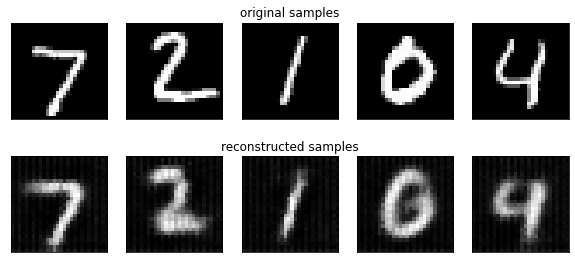

batch loss in training:	  9851.584961
batch loss in training:	  9838.264648
batch loss in training:	  10079.549805
batch loss in training:	  9708.472656
batch loss in training:	  9944.698242
batch loss in training:	  9885.077148
batch loss in training:	  10174.912109
batch loss in training:	  9992.221680
batch loss in training:	  9870.412109
batch loss in training:	  9821.833008
batch loss in training:	  9609.269531
batch loss in training:	  9731.312500
batch loss in training:	  9946.232422
batch loss in training:	  9765.175781
batch loss in training:	  9962.745117
batch loss in training:	  9861.686523
batch loss in training:	  9630.018555
batch loss in training:	  9499.958984
batch loss in training:	  9504.113281
batch loss in training:	  9876.107422
batch loss in training:	  9366.125977
batch loss in training:	  10150.705078
batch loss in training:	  9802.654297
batch loss in training:	  9647.850586
batch loss in training:	  9792.200195
batch loss in training:	  9848.974609
batch los

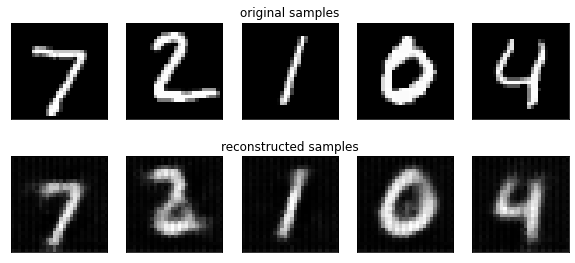

batch loss in training:	  9433.494141
batch loss in training:	  9396.618164
batch loss in training:	  9606.414062
batch loss in training:	  9281.750000
batch loss in training:	  9394.810547
batch loss in training:	  9360.910156
batch loss in training:	  9792.119141
batch loss in training:	  9486.391602
batch loss in training:	  9360.876953
batch loss in training:	  9436.823242
batch loss in training:	  9097.341797
batch loss in training:	  9289.946289
batch loss in training:	  9483.466797
batch loss in training:	  9285.358398
batch loss in training:	  9564.080078
batch loss in training:	  9411.958984
batch loss in training:	  9156.784180
batch loss in training:	  9009.657227
batch loss in training:	  9125.051758
batch loss in training:	  9422.002930
batch loss in training:	  8804.998047
batch loss in training:	  9720.787109
batch loss in training:	  9435.094727
batch loss in training:	  9239.416992
batch loss in training:	  9386.941406
batch loss in training:	  9458.079102
batch loss i

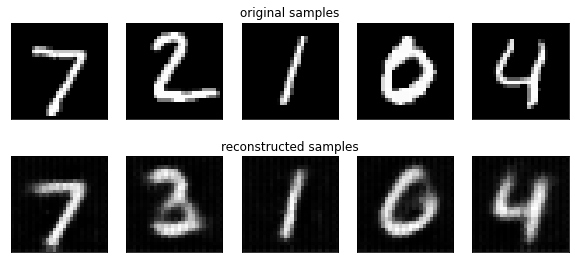

batch loss in training:	  9114.012695
batch loss in training:	  9234.894531
batch loss in training:	  9405.128906
batch loss in training:	  9119.436523
batch loss in training:	  9268.940430
batch loss in training:	  9115.191406
batch loss in training:	  9623.923828
batch loss in training:	  9164.398438
batch loss in training:	  9177.795898
batch loss in training:	  9201.144531
batch loss in training:	  9046.949219
batch loss in training:	  9108.953125
batch loss in training:	  9173.040039
batch loss in training:	  9052.844727
batch loss in training:	  9284.460938
batch loss in training:	  9218.858398
batch loss in training:	  8970.831055
batch loss in training:	  8929.320312
batch loss in training:	  8929.466797
batch loss in training:	  9300.396484
batch loss in training:	  8643.201172
batch loss in training:	  9501.149414
batch loss in training:	  9364.851562
batch loss in training:	  9000.732422
batch loss in training:	  9208.041016
batch loss in training:	  9322.362305
batch loss i

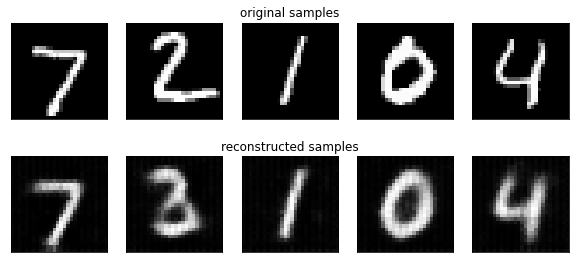

batch loss in training:	  8958.643555
batch loss in training:	  8972.375000
batch loss in training:	  9287.342773
batch loss in training:	  8906.715820
batch loss in training:	  9000.036133
batch loss in training:	  9062.080078
batch loss in training:	  9425.518555
batch loss in training:	  9018.062500
batch loss in training:	  9057.351562
batch loss in training:	  8972.264648
batch loss in training:	  8805.523438
batch loss in training:	  8878.393555
batch loss in training:	  9128.829102
batch loss in training:	  8887.242188
batch loss in training:	  9150.257812
batch loss in training:	  8992.980469
batch loss in training:	  8713.855469
batch loss in training:	  8607.219727
batch loss in training:	  8827.791016
batch loss in training:	  9041.281250
batch loss in training:	  8485.382812
batch loss in training:	  9421.708984
batch loss in training:	  9211.937500
batch loss in training:	  8897.616211
batch loss in training:	  9043.986328
batch loss in training:	  9081.948242
batch loss i

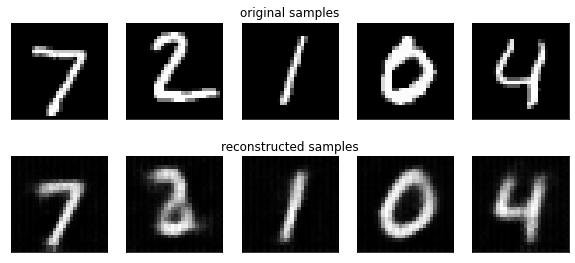

batch loss in training:	  8902.240234
batch loss in training:	  9023.990234
batch loss in training:	  9159.183594
batch loss in training:	  8918.046875
batch loss in training:	  8961.903320
batch loss in training:	  8959.005859
batch loss in training:	  9364.178711
batch loss in training:	  8929.146484
batch loss in training:	  8990.585938
batch loss in training:	  8957.983398
batch loss in training:	  8770.238281
batch loss in training:	  8745.279297
batch loss in training:	  8986.038086
batch loss in training:	  8761.350586
batch loss in training:	  9035.779297
batch loss in training:	  8910.809570
batch loss in training:	  8662.486328
batch loss in training:	  8475.431641
batch loss in training:	  8748.214844
batch loss in training:	  9099.448242
batch loss in training:	  8430.635742
batch loss in training:	  9222.648438
batch loss in training:	  9155.826172
batch loss in training:	  8793.558594
batch loss in training:	  8927.966797
batch loss in training:	  9117.029297
batch loss i

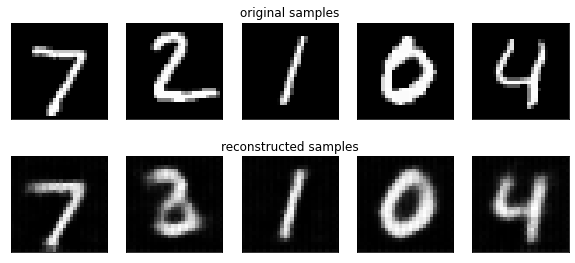

batch loss in training:	  8739.222656
batch loss in training:	  8927.821289
batch loss in training:	  9074.718750
batch loss in training:	  8801.312500
batch loss in training:	  8866.134766
batch loss in training:	  8853.762695
batch loss in training:	  9192.503906
batch loss in training:	  8927.512695
batch loss in training:	  8938.410156
batch loss in training:	  8857.808594
batch loss in training:	  8667.483398
batch loss in training:	  8760.710938
batch loss in training:	  8847.015625
batch loss in training:	  8716.625977
batch loss in training:	  8987.710938
batch loss in training:	  8906.738281
batch loss in training:	  8575.156250
batch loss in training:	  8555.267578
batch loss in training:	  8730.753906
batch loss in training:	  8960.050781
batch loss in training:	  8315.068359
batch loss in training:	  9244.046875
batch loss in training:	  9076.820312
batch loss in training:	  8733.365234
batch loss in training:	  8827.861328
batch loss in training:	  9036.953125
batch loss i

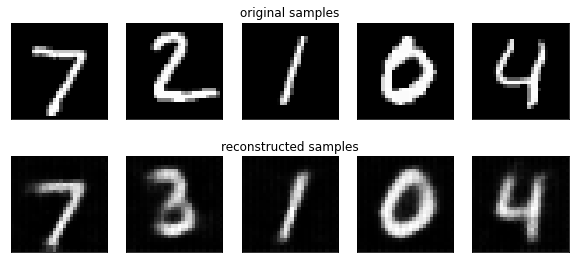

batch loss in training:	  8759.776367
batch loss in training:	  8859.678711
batch loss in training:	  8942.960938
batch loss in training:	  8739.818359
batch loss in training:	  8823.679688
batch loss in training:	  8760.783203
batch loss in training:	  9204.302734
batch loss in training:	  8749.851562
batch loss in training:	  8855.378906
batch loss in training:	  8845.571289
batch loss in training:	  8604.822266
batch loss in training:	  8674.177734
batch loss in training:	  8833.552734
batch loss in training:	  8700.335938
batch loss in training:	  8948.740234
batch loss in training:	  8840.764648
batch loss in training:	  8572.761719
batch loss in training:	  8416.296875
batch loss in training:	  8659.524414
batch loss in training:	  8925.007812
batch loss in training:	  8274.512695
batch loss in training:	  9173.593750
batch loss in training:	  9071.628906
batch loss in training:	  8635.839844
batch loss in training:	  8829.022461
batch loss in training:	  8953.740234
batch loss i

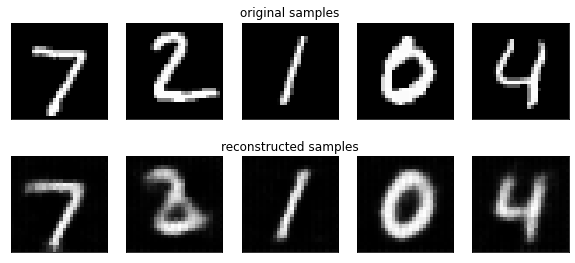

batch loss in training:	  8727.201172
batch loss in training:	  8833.036133
batch loss in training:	  9000.893555
batch loss in training:	  8645.408203
batch loss in training:	  8686.240234
batch loss in training:	  8710.692383
batch loss in training:	  9204.913086
batch loss in training:	  8733.978516
batch loss in training:	  8782.297852
batch loss in training:	  8776.303711
batch loss in training:	  8498.486328
batch loss in training:	  8590.239258
batch loss in training:	  8788.941406
batch loss in training:	  8508.879883
batch loss in training:	  8811.766602
batch loss in training:	  8784.019531
batch loss in training:	  8581.088867
batch loss in training:	  8365.855469
batch loss in training:	  8566.525391
batch loss in training:	  8863.251953
batch loss in training:	  8184.872070
batch loss in training:	  9082.300781
batch loss in training:	  8961.289062
batch loss in training:	  8564.894531
batch loss in training:	  8708.879883
batch loss in training:	  8932.056641
batch loss i

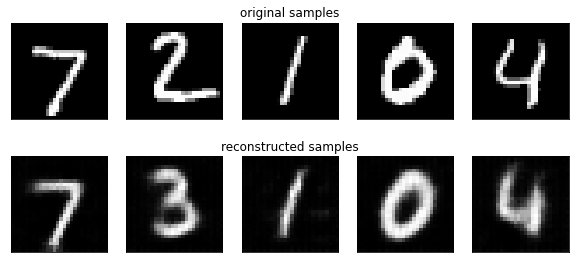

batch loss in training:	  8656.299805
batch loss in training:	  8825.136719
batch loss in training:	  8945.465820
batch loss in training:	  8640.243164
batch loss in training:	  8752.941406
batch loss in training:	  8726.087891
batch loss in training:	  9018.111328
batch loss in training:	  8643.078125
batch loss in training:	  8860.509766
batch loss in training:	  8763.356445
batch loss in training:	  8574.800781
batch loss in training:	  8593.984375
batch loss in training:	  8749.075195
batch loss in training:	  8653.366211
batch loss in training:	  8803.252930
batch loss in training:	  8742.445312
batch loss in training:	  8418.920898
batch loss in training:	  8314.800781
batch loss in training:	  8559.100586
batch loss in training:	  8771.904297
batch loss in training:	  8108.592285
batch loss in training:	  9130.001953
batch loss in training:	  8953.283203
batch loss in training:	  8531.747070
batch loss in training:	  8707.343750
batch loss in training:	  8840.388672
batch loss i

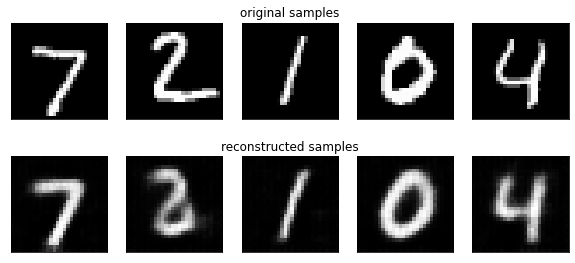

batch loss in training:	  8648.280273
batch loss in training:	  8784.789062
batch loss in training:	  8845.858398
batch loss in training:	  8565.611328
batch loss in training:	  8689.371094
batch loss in training:	  8590.370117
batch loss in training:	  8942.949219
batch loss in training:	  8633.270508
batch loss in training:	  8723.750000
batch loss in training:	  8657.431641
batch loss in training:	  8440.256836
batch loss in training:	  8487.304688
batch loss in training:	  8665.001953
batch loss in training:	  8472.872070
batch loss in training:	  8786.060547
batch loss in training:	  8729.641602
batch loss in training:	  8367.187500
batch loss in training:	  8248.960938
batch loss in training:	  8471.595703
batch loss in training:	  8782.273438
batch loss in training:	  8115.082031
batch loss in training:	  8936.061523
batch loss in training:	  8906.380859
batch loss in training:	  8484.676758
batch loss in training:	  8621.550781
batch loss in training:	  8842.710938
batch loss i

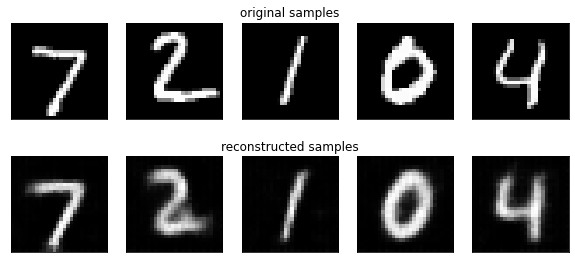

batch loss in training:	  8600.088867
batch loss in training:	  8758.806641
batch loss in training:	  8899.578125
batch loss in training:	  8537.612305
batch loss in training:	  8612.130859
batch loss in training:	  8560.621094
batch loss in training:	  9001.115234
batch loss in training:	  8581.800781
batch loss in training:	  8768.366211
batch loss in training:	  8685.767578
batch loss in training:	  8487.656250
batch loss in training:	  8476.546875
batch loss in training:	  8740.949219
batch loss in training:	  8466.106445
batch loss in training:	  8709.822266
batch loss in training:	  8634.208984
batch loss in training:	  8403.480469
batch loss in training:	  8313.310547
batch loss in training:	  8474.504883
batch loss in training:	  8755.791016
batch loss in training:	  8068.063965
batch loss in training:	  8959.777344
batch loss in training:	  8912.099609
batch loss in training:	  8489.287109
batch loss in training:	  8579.492188
batch loss in training:	  8769.837891
batch loss i

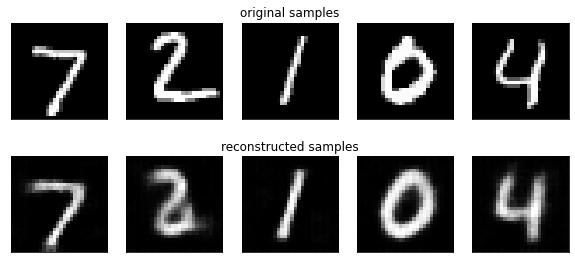

batch loss in training:	  8483.061523
batch loss in training:	  8568.832031
batch loss in training:	  8848.539062
batch loss in training:	  8558.699219
batch loss in training:	  8589.257812
batch loss in training:	  8502.576172
batch loss in training:	  8959.977539
batch loss in training:	  8642.672852
batch loss in training:	  8675.211914
batch loss in training:	  8595.096680
batch loss in training:	  8491.438477
batch loss in training:	  8585.048828
batch loss in training:	  8751.278320
batch loss in training:	  8505.649414
batch loss in training:	  8728.141602
batch loss in training:	  8650.871094
batch loss in training:	  8301.617188
batch loss in training:	  8264.618164
batch loss in training:	  8476.283203
batch loss in training:	  8748.157227
batch loss in training:	  7931.246094
batch loss in training:	  8948.474609
batch loss in training:	  8854.183594
batch loss in training:	  8458.564453
batch loss in training:	  8497.498047
batch loss in training:	  8701.925781
batch loss i

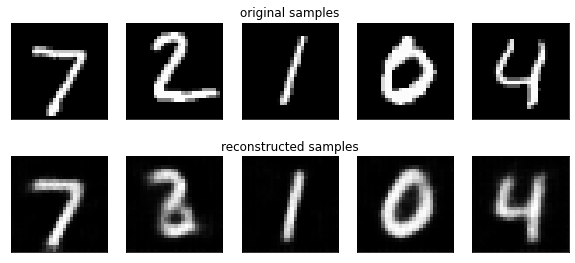

batch loss in training:	  8470.016602
batch loss in training:	  8572.789062
batch loss in training:	  8762.960938
batch loss in training:	  8506.646484
batch loss in training:	  8587.145508
batch loss in training:	  8597.541992
batch loss in training:	  8928.115234
batch loss in training:	  8594.193359
batch loss in training:	  8632.318359
batch loss in training:	  8578.666016
batch loss in training:	  8410.546875
batch loss in training:	  8540.330078
batch loss in training:	  8623.818359
batch loss in training:	  8436.349609
batch loss in training:	  8708.611328
batch loss in training:	  8667.928711
batch loss in training:	  8296.052734
batch loss in training:	  8244.046875
batch loss in training:	  8429.652344
batch loss in training:	  8710.962891
batch loss in training:	  7950.160156
batch loss in training:	  8977.777344
batch loss in training:	  8851.266602
batch loss in training:	  8421.823242
batch loss in training:	  8559.080078
batch loss in training:	  8771.020508
batch loss i

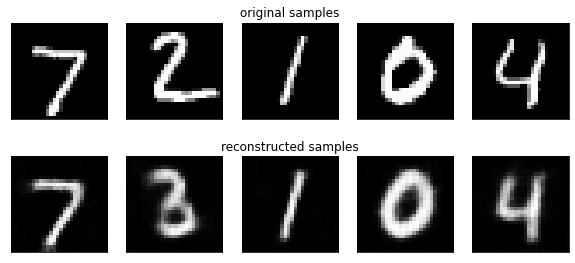

batch loss in training:	  8476.092773
batch loss in training:	  8596.406250
batch loss in training:	  8768.164062
batch loss in training:	  8538.576172
batch loss in training:	  8478.425781
batch loss in training:	  8466.648438
batch loss in training:	  8981.763672
batch loss in training:	  8513.367188
batch loss in training:	  8643.775391
batch loss in training:	  8534.794922
batch loss in training:	  8403.087891
batch loss in training:	  8518.222656
batch loss in training:	  8627.603516
batch loss in training:	  8427.056641
batch loss in training:	  8629.042969
batch loss in training:	  8624.676758
batch loss in training:	  8265.625000
batch loss in training:	  8212.003906
batch loss in training:	  8365.880859
batch loss in training:	  8664.526367
batch loss in training:	  7937.641602
batch loss in training:	  8951.941406
batch loss in training:	  8809.548828
batch loss in training:	  8431.608398
batch loss in training:	  8536.541016
batch loss in training:	  8700.308594
batch loss i

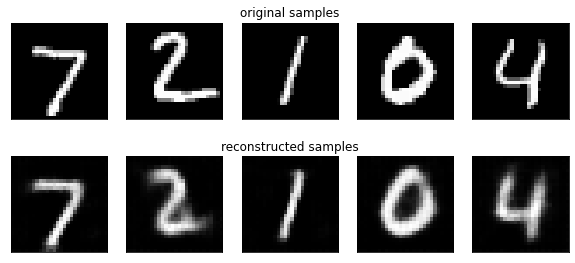

batch loss in training:	  8418.732422
batch loss in training:	  8562.567383
batch loss in training:	  8764.003906
batch loss in training:	  8453.154297
batch loss in training:	  8486.764648
batch loss in training:	  8467.557617
batch loss in training:	  8973.252930
batch loss in training:	  8520.793945
batch loss in training:	  8579.027344
batch loss in training:	  8618.144531
batch loss in training:	  8384.988281
batch loss in training:	  8440.640625
batch loss in training:	  8566.742188
batch loss in training:	  8471.535156
batch loss in training:	  8717.277344
batch loss in training:	  8492.062500
batch loss in training:	  8225.537109
batch loss in training:	  8167.539062
batch loss in training:	  8408.192383
batch loss in training:	  8651.096680
batch loss in training:	  7943.402832
batch loss in training:	  8858.421875
batch loss in training:	  8775.013672
batch loss in training:	  8441.332031
batch loss in training:	  8429.556641
batch loss in training:	  8721.275391
batch loss i

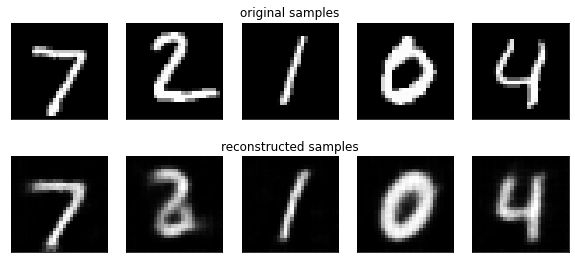

batch loss in training:	  8388.950195
batch loss in training:	  8555.488281
batch loss in training:	  8689.863281
batch loss in training:	  8370.402344
batch loss in training:	  8569.883789
batch loss in training:	  8476.423828
batch loss in training:	  8870.201172
batch loss in training:	  8443.675781
batch loss in training:	  8627.046875
batch loss in training:	  8489.806641
batch loss in training:	  8307.580078
batch loss in training:	  8395.635742
batch loss in training:	  8582.744141
batch loss in training:	  8428.186523
batch loss in training:	  8572.978516
batch loss in training:	  8524.384766
batch loss in training:	  8219.785156
batch loss in training:	  8167.980469
batch loss in training:	  8403.504883
batch loss in training:	  8633.638672
batch loss in training:	  7848.735352
batch loss in training:	  8872.013672
batch loss in training:	  8776.599609
batch loss in training:	  8321.750000
batch loss in training:	  8503.878906
batch loss in training:	  8621.062500
batch loss i

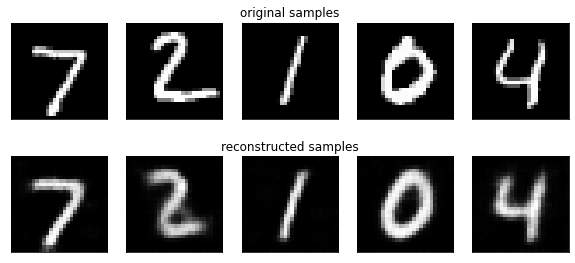

batch loss in training:	  8419.080078
batch loss in training:	  8512.694336
batch loss in training:	  8739.404297
batch loss in training:	  8402.266602
batch loss in training:	  8499.604492
batch loss in training:	  8491.814453
batch loss in training:	  8806.171875
batch loss in training:	  8420.261719
batch loss in training:	  8502.818359
batch loss in training:	  8519.435547
batch loss in training:	  8315.302734
batch loss in training:	  8382.964844
batch loss in training:	  8576.805664
batch loss in training:	  8392.810547
batch loss in training:	  8575.495117
batch loss in training:	  8626.148438
batch loss in training:	  8217.322266
batch loss in training:	  8113.728027
batch loss in training:	  8320.929688
batch loss in training:	  8541.977539
batch loss in training:	  7887.607422
batch loss in training:	  8846.021484
batch loss in training:	  8750.961914
batch loss in training:	  8406.822266
batch loss in training:	  8440.968750
batch loss in training:	  8644.572266
batch loss i

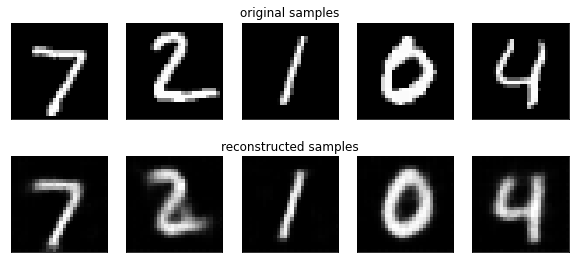

batch loss in training:	  8309.263672
batch loss in training:	  8559.479492
batch loss in training:	  8684.708984
batch loss in training:	  8422.048828
batch loss in training:	  8496.073242
batch loss in training:	  8500.609375
batch loss in training:	  8846.212891
batch loss in training:	  8455.934570
batch loss in training:	  8557.041992
batch loss in training:	  8433.948242
batch loss in training:	  8277.451172
batch loss in training:	  8414.958984
batch loss in training:	  8573.056641
batch loss in training:	  8322.262695
batch loss in training:	  8609.556641
batch loss in training:	  8547.308594
batch loss in training:	  8246.961914
batch loss in training:	  8052.992188
batch loss in training:	  8339.902344
batch loss in training:	  8505.613281
batch loss in training:	  7862.402344
batch loss in training:	  8790.099609
batch loss in training:	  8824.763672
batch loss in training:	  8336.472656
batch loss in training:	  8359.741211
batch loss in training:	  8663.092773
batch loss i

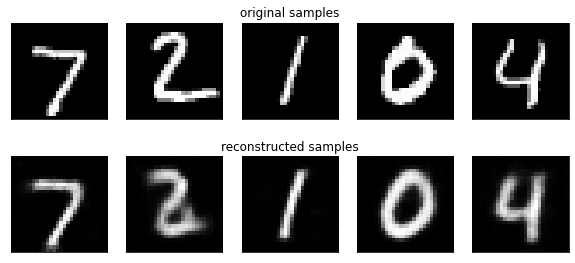

batch loss in training:	  8383.933594
batch loss in training:	  8450.145508
batch loss in training:	  8647.431641
batch loss in training:	  8458.546875
batch loss in training:	  8475.912109
batch loss in training:	  8404.553711
batch loss in training:	  8830.556641
batch loss in training:	  8387.363281
batch loss in training:	  8480.927734
batch loss in training:	  8559.892578
batch loss in training:	  8341.065430
batch loss in training:	  8394.647461
batch loss in training:	  8607.488281
batch loss in training:	  8348.100586
batch loss in training:	  8622.500000
batch loss in training:	  8513.153320
batch loss in training:	  8253.325195
batch loss in training:	  8176.385742
batch loss in training:	  8245.374023
batch loss in training:	  8591.208984
batch loss in training:	  7874.680176
batch loss in training:	  8807.886719
batch loss in training:	  8630.961914
batch loss in training:	  8314.983398
batch loss in training:	  8356.933594
batch loss in training:	  8635.000000
batch loss i

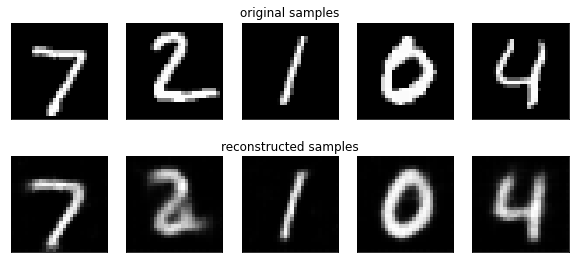

batch loss in training:	  8326.473633
batch loss in training:	  8532.115234
batch loss in training:	  8620.983398
batch loss in training:	  8381.361328
batch loss in training:	  8467.890625
batch loss in training:	  8366.005859
batch loss in training:	  8821.475586
batch loss in training:	  8391.166992
batch loss in training:	  8552.474609
batch loss in training:	  8384.507812
batch loss in training:	  8273.400391
batch loss in training:	  8339.410156
batch loss in training:	  8511.095703
batch loss in training:	  8331.958008
batch loss in training:	  8552.845703
batch loss in training:	  8480.919922
batch loss in training:	  8214.640625
batch loss in training:	  8072.885742
batch loss in training:	  8266.730469
batch loss in training:	  8510.143555
batch loss in training:	  7816.851074
batch loss in training:	  8733.296875
batch loss in training:	  8742.831055
batch loss in training:	  8283.705078
batch loss in training:	  8467.031250
batch loss in training:	  8623.058594
batch loss i

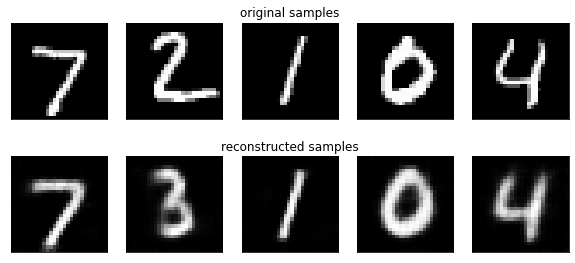

batch loss in training:	  8331.421875
batch loss in training:	  8541.891602
batch loss in training:	  8693.876953
batch loss in training:	  8476.226562
batch loss in training:	  8382.832031
batch loss in training:	  8354.843750
batch loss in training:	  8797.916016
batch loss in training:	  8444.023438
batch loss in training:	  8471.345703
batch loss in training:	  8434.719727
batch loss in training:	  8299.354492
batch loss in training:	  8349.285156
batch loss in training:	  8510.230469
batch loss in training:	  8275.726562
batch loss in training:	  8555.025391
batch loss in training:	  8477.048828
batch loss in training:	  8221.949219
batch loss in training:	  8102.233887
batch loss in training:	  8302.896484
batch loss in training:	  8509.402344
batch loss in training:	  7852.932617
batch loss in training:	  8742.179688
batch loss in training:	  8713.659180
batch loss in training:	  8278.801758
batch loss in training:	  8403.603516
batch loss in training:	  8625.124023
batch loss i

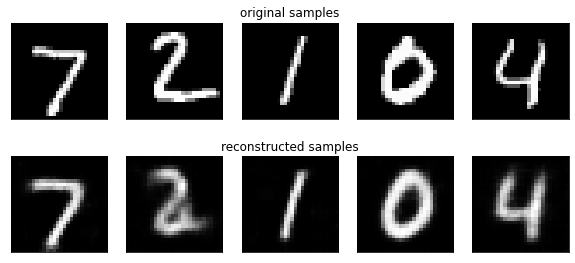

batch loss in training:	  8283.005859
batch loss in training:	  8420.000000
batch loss in training:	  8587.824219
batch loss in training:	  8397.105469
batch loss in training:	  8373.430664
batch loss in training:	  8336.381836
batch loss in training:	  8826.095703
batch loss in training:	  8351.845703
batch loss in training:	  8482.580078
batch loss in training:	  8404.967773
batch loss in training:	  8215.756836
batch loss in training:	  8332.757812
batch loss in training:	  8508.544922
batch loss in training:	  8324.240234
batch loss in training:	  8572.400391
batch loss in training:	  8468.957031
batch loss in training:	  8101.671875
batch loss in training:	  8174.747559
batch loss in training:	  8255.898438
batch loss in training:	  8495.016602
batch loss in training:	  7798.084473
batch loss in training:	  8753.010742
batch loss in training:	  8662.105469
batch loss in training:	  8230.649414
batch loss in training:	  8353.822266
batch loss in training:	  8624.515625
batch loss i

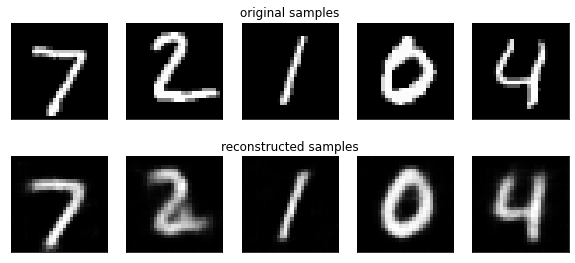

batch loss in training:	  8235.218750
batch loss in training:	  8350.468750
batch loss in training:	  8577.016602
batch loss in training:	  8321.701172
batch loss in training:	  8410.832031
batch loss in training:	  8367.272461
batch loss in training:	  8778.116211
batch loss in training:	  8328.656250
batch loss in training:	  8377.217773
batch loss in training:	  8439.135742
batch loss in training:	  8216.673828
batch loss in training:	  8322.687500
batch loss in training:	  8409.374023
batch loss in training:	  8269.318359
batch loss in training:	  8577.667969
batch loss in training:	  8522.043945
batch loss in training:	  8150.675781
batch loss in training:	  8096.550293
batch loss in training:	  8219.803711
batch loss in training:	  8518.458984
batch loss in training:	  7840.480469
batch loss in training:	  8776.689453
batch loss in training:	  8633.904297
batch loss in training:	  8301.820312
batch loss in training:	  8331.672852
batch loss in training:	  8622.708008
batch loss i

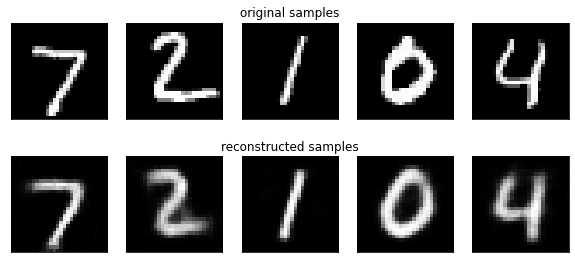

batch loss in training:	  8241.917969
batch loss in training:	  8442.833008
batch loss in training:	  8525.887695
batch loss in training:	  8329.910156
batch loss in training:	  8357.863281
batch loss in training:	  8382.671875
batch loss in training:	  8785.597656
batch loss in training:	  8305.271484
batch loss in training:	  8387.708008
batch loss in training:	  8355.734375
batch loss in training:	  8300.654297
batch loss in training:	  8300.047852
batch loss in training:	  8452.330078
batch loss in training:	  8380.275391
batch loss in training:	  8496.887695
batch loss in training:	  8429.682617
batch loss in training:	  8120.321777
batch loss in training:	  7989.586426
batch loss in training:	  8253.154297
batch loss in training:	  8539.197266
batch loss in training:	  7829.742676
batch loss in training:	  8611.270508
batch loss in training:	  8687.237305
batch loss in training:	  8231.054688
batch loss in training:	  8385.661133
batch loss in training:	  8490.371094
batch loss i

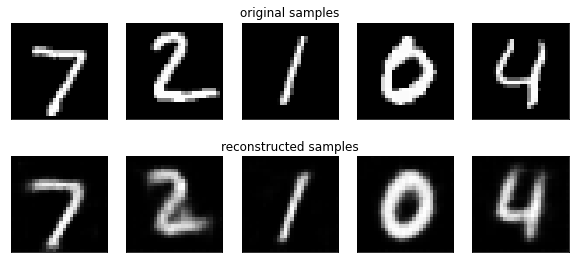

batch loss in training:	  8318.093750
batch loss in training:	  8389.283203
batch loss in training:	  8588.512695
batch loss in training:	  8301.690430
batch loss in training:	  8392.235352
batch loss in training:	  8361.599609
batch loss in training:	  8670.568359
batch loss in training:	  8339.411133
batch loss in training:	  8412.494141
batch loss in training:	  8417.858398
batch loss in training:	  8199.836914
batch loss in training:	  8299.136719
batch loss in training:	  8388.669922
batch loss in training:	  8236.189453
batch loss in training:	  8548.445312
batch loss in training:	  8467.742188
batch loss in training:	  8149.967285
batch loss in training:	  8151.874023
batch loss in training:	  8260.369141
batch loss in training:	  8473.780273
batch loss in training:	  7747.404297
batch loss in training:	  8747.968750
batch loss in training:	  8705.810547
batch loss in training:	  8283.580078
batch loss in training:	  8315.558594
batch loss in training:	  8595.079102
batch loss i

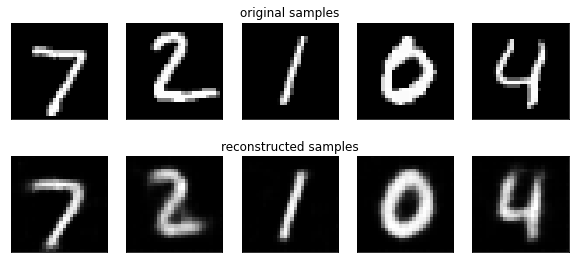

batch loss in training:	  8216.744141
batch loss in training:	  8365.568359
batch loss in training:	  8515.765625
batch loss in training:	  8328.497070
batch loss in training:	  8331.226562
batch loss in training:	  8319.826172
batch loss in training:	  8660.967773
batch loss in training:	  8346.792969
batch loss in training:	  8415.638672
batch loss in training:	  8257.132812
batch loss in training:	  8272.009766
batch loss in training:	  8339.812500
batch loss in training:	  8479.992188
batch loss in training:	  8286.230469
batch loss in training:	  8468.184570
batch loss in training:	  8424.564453
batch loss in training:	  8195.318359
batch loss in training:	  8069.192383
batch loss in training:	  8253.533203
batch loss in training:	  8464.816406
batch loss in training:	  7699.717285
batch loss in training:	  8685.746094
batch loss in training:	  8643.896484
batch loss in training:	  8301.509766
batch loss in training:	  8266.562500
batch loss in training:	  8540.465820
batch loss i

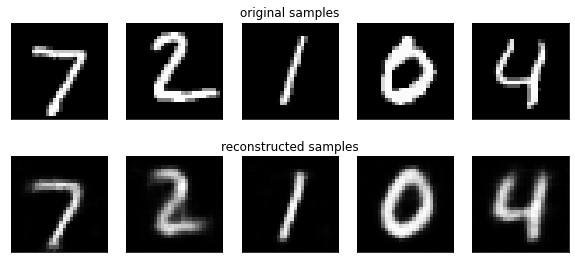

batch loss in training:	  8220.824219
batch loss in training:	  8349.590820
batch loss in training:	  8522.730469
batch loss in training:	  8327.946289
batch loss in training:	  8361.024414
batch loss in training:	  8239.886719
batch loss in training:	  8707.183594
batch loss in training:	  8269.412109
batch loss in training:	  8436.001953
batch loss in training:	  8290.769531
batch loss in training:	  8164.089844
batch loss in training:	  8255.982422
batch loss in training:	  8392.638672
batch loss in training:	  8257.102539
batch loss in training:	  8471.914062
batch loss in training:	  8440.982422
batch loss in training:	  8155.454102
batch loss in training:	  7981.299316
batch loss in training:	  8239.107422
batch loss in training:	  8466.049805
batch loss in training:	  7742.252930
batch loss in training:	  8719.461914
batch loss in training:	  8622.209961
batch loss in training:	  8226.589844
batch loss in training:	  8296.890625
batch loss in training:	  8520.785156
batch loss i

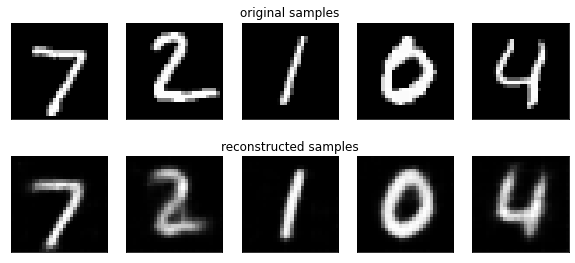

batch loss in training:	  8193.011719
batch loss in training:	  8448.767578
batch loss in training:	  8515.935547
batch loss in training:	  8270.482422
batch loss in training:	  8365.169922
batch loss in training:	  8368.469727
batch loss in training:	  8737.941406
batch loss in training:	  8275.093750
batch loss in training:	  8387.161133
batch loss in training:	  8357.910156
batch loss in training:	  8210.437500
batch loss in training:	  8225.445312
batch loss in training:	  8455.628906
batch loss in training:	  8137.552734
batch loss in training:	  8444.923828
batch loss in training:	  8432.359375
batch loss in training:	  8098.978516
batch loss in training:	  7990.231445
batch loss in training:	  8197.769531
batch loss in training:	  8475.821289
batch loss in training:	  7710.167480
batch loss in training:	  8671.758789
batch loss in training:	  8574.592773
batch loss in training:	  8219.002930
batch loss in training:	  8269.214844
batch loss in training:	  8556.800781
batch loss i

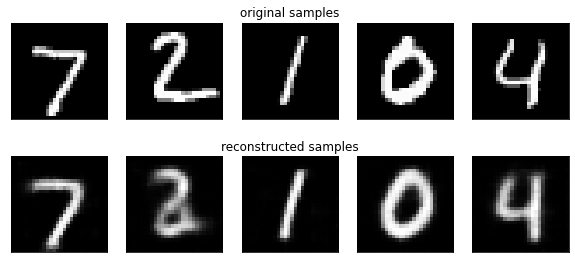

batch loss in training:	  8234.062500
batch loss in training:	  8362.070312
batch loss in training:	  8511.525391
batch loss in training:	  8259.865234
batch loss in training:	  8322.136719
batch loss in training:	  8297.305664
batch loss in training:	  8632.117188
batch loss in training:	  8338.569336
batch loss in training:	  8337.514648
batch loss in training:	  8265.019531
batch loss in training:	  8175.756836
batch loss in training:	  8300.113281
batch loss in training:	  8325.857422
batch loss in training:	  8185.597168
batch loss in training:	  8429.097656
batch loss in training:	  8391.261719
batch loss in training:	  8083.759766
batch loss in training:	  8013.501465
batch loss in training:	  8218.595703
batch loss in training:	  8425.992188
batch loss in training:	  7768.550781
batch loss in training:	  8695.667969
batch loss in training:	  8598.689453
batch loss in training:	  8151.833984
batch loss in training:	  8288.220703
batch loss in training:	  8528.445312
batch loss i

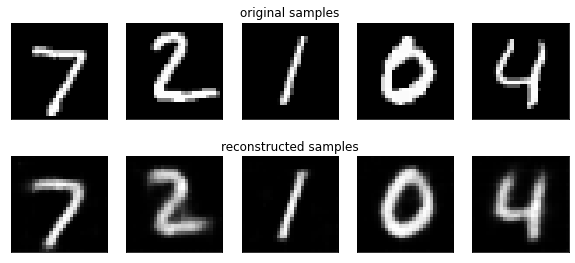

batch loss in training:	  8185.944336
batch loss in training:	  8392.218750
batch loss in training:	  8458.861328
batch loss in training:	  8299.542969
batch loss in training:	  8239.617188
batch loss in training:	  8211.306641
batch loss in training:	  8669.677734
batch loss in training:	  8285.777344
batch loss in training:	  8340.490234
batch loss in training:	  8294.768555
batch loss in training:	  8173.930664
batch loss in training:	  8231.183594
batch loss in training:	  8350.361328
batch loss in training:	  8155.971191
batch loss in training:	  8498.832031
batch loss in training:	  8370.451172
batch loss in training:	  8082.399414
batch loss in training:	  8026.500488
batch loss in training:	  8147.258789
batch loss in training:	  8442.855469
batch loss in training:	  7761.595703
batch loss in training:	  8695.649414
batch loss in training:	  8635.869141
batch loss in training:	  8174.743652
batch loss in training:	  8254.034180
batch loss in training:	  8495.625977
batch loss i

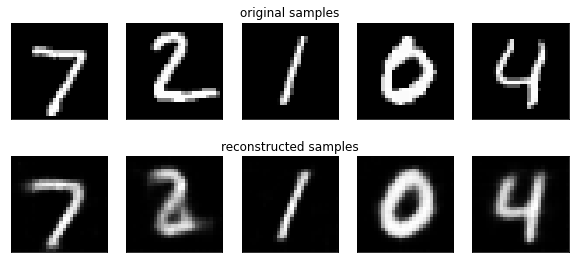

batch loss in training:	  8202.804688
batch loss in training:	  8375.281250
batch loss in training:	  8486.984375
batch loss in training:	  8302.775391
batch loss in training:	  8319.715820
batch loss in training:	  8293.137695
batch loss in training:	  8653.734375
batch loss in training:	  8261.789062
batch loss in training:	  8389.538086
batch loss in training:	  8233.397461
batch loss in training:	  8132.356445
batch loss in training:	  8296.902344
batch loss in training:	  8389.333008
batch loss in training:	  8241.746094
batch loss in training:	  8421.845703
batch loss in training:	  8445.414062
batch loss in training:	  8061.002930
batch loss in training:	  7948.380859
batch loss in training:	  8205.054688
batch loss in training:	  8395.918945
batch loss in training:	  7665.881836
batch loss in training:	  8674.935547
batch loss in training:	  8617.589844
batch loss in training:	  8129.942871
batch loss in training:	  8214.698242
batch loss in training:	  8439.608398
batch loss i

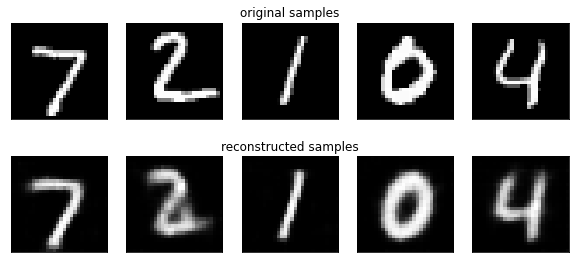

batch loss in training:	  8248.199219
batch loss in training:	  8332.236328
batch loss in training:	  8543.065430
batch loss in training:	  8290.248047
batch loss in training:	  8340.763672
batch loss in training:	  8273.181641
batch loss in training:	  8640.550781
batch loss in training:	  8234.031250
batch loss in training:	  8343.160156
batch loss in training:	  8298.980469
batch loss in training:	  8182.020508
batch loss in training:	  8262.571289
batch loss in training:	  8389.299805
batch loss in training:	  8166.806641
batch loss in training:	  8419.820312
batch loss in training:	  8351.156250
batch loss in training:	  8007.467773
batch loss in training:	  8042.505859
batch loss in training:	  8139.041992
batch loss in training:	  8384.789062
batch loss in training:	  7670.320312
batch loss in training:	  8658.360352
batch loss in training:	  8598.584961
batch loss in training:	  8186.706543
batch loss in training:	  8322.504883
batch loss in training:	  8505.904297
batch loss i

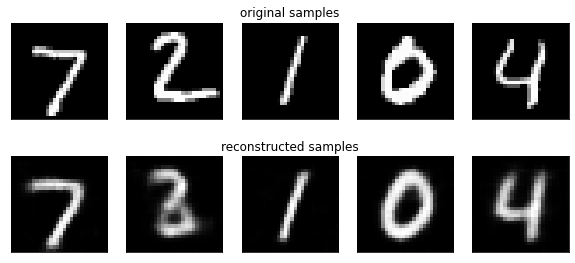

batch loss in training:	  8163.034180
batch loss in training:	  8305.909180
batch loss in training:	  8465.966797
batch loss in training:	  8260.041016
batch loss in training:	  8291.978516
batch loss in training:	  8267.056641
batch loss in training:	  8696.862305
batch loss in training:	  8228.528320
batch loss in training:	  8384.683594
batch loss in training:	  8276.365234
batch loss in training:	  8201.674805
batch loss in training:	  8186.851074
batch loss in training:	  8392.884766
batch loss in training:	  8259.943359
batch loss in training:	  8463.324219
batch loss in training:	  8332.296875
batch loss in training:	  8043.760742
batch loss in training:	  7951.532227
batch loss in training:	  8185.943359
batch loss in training:	  8331.885742
batch loss in training:	  7603.219727
batch loss in training:	  8732.830078
batch loss in training:	  8623.027344
batch loss in training:	  8129.837891
batch loss in training:	  8256.550781
batch loss in training:	  8421.388672
batch loss i

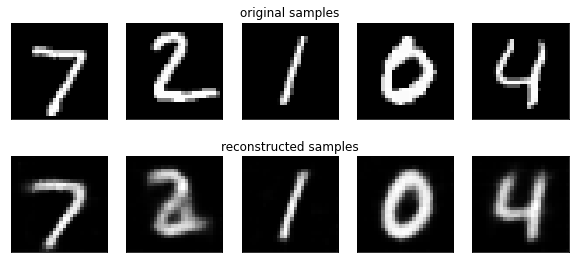

batch loss in training:	  8097.919922
batch loss in training:	  8270.448242
batch loss in training:	  8480.059570
batch loss in training:	  8221.478516
batch loss in training:	  8228.308594
batch loss in training:	  8263.323242
batch loss in training:	  8626.933594
batch loss in training:	  8291.139648
batch loss in training:	  8315.818359
batch loss in training:	  8231.162109
batch loss in training:	  8172.587891
batch loss in training:	  8190.666992
batch loss in training:	  8389.960938
batch loss in training:	  8247.929688
batch loss in training:	  8444.411133
batch loss in training:	  8323.945312
batch loss in training:	  8048.909180
batch loss in training:	  8026.122559
batch loss in training:	  8173.064453
batch loss in training:	  8354.772461
batch loss in training:	  7704.013672
batch loss in training:	  8652.396484
batch loss in training:	  8581.406250
batch loss in training:	  8139.468262
batch loss in training:	  8269.824219
batch loss in training:	  8460.123047
batch loss i

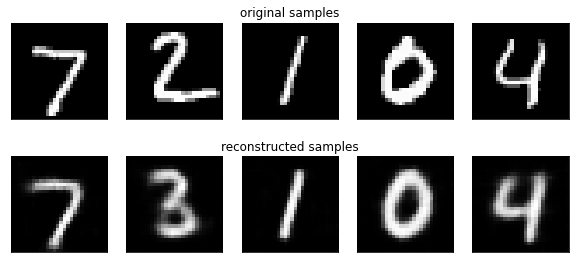

batch loss in training:	  8155.478516
batch loss in training:	  8332.639648
batch loss in training:	  8463.849609
batch loss in training:	  8212.873047
batch loss in training:	  8344.807617
batch loss in training:	  8290.589844
batch loss in training:	  8611.323242
batch loss in training:	  8205.992188
batch loss in training:	  8213.025391
batch loss in training:	  8254.326172
batch loss in training:	  8139.131348
batch loss in training:	  8226.073242
batch loss in training:	  8363.842773
batch loss in training:	  8237.777344
batch loss in training:	  8436.568359
batch loss in training:	  8399.042969
batch loss in training:	  8049.809082
batch loss in training:	  7977.527832
batch loss in training:	  8181.286133
batch loss in training:	  8420.210938
batch loss in training:	  7688.076172
batch loss in training:	  8624.439453
batch loss in training:	  8573.787109
batch loss in training:	  8180.505859
batch loss in training:	  8158.939941
batch loss in training:	  8512.072266
batch loss i

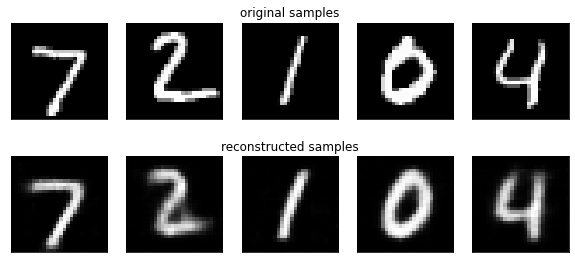

batch loss in training:	  8080.991699
batch loss in training:	  8259.509766
batch loss in training:	  8415.353516
batch loss in training:	  8318.227539
batch loss in training:	  8274.210938
batch loss in training:	  8234.718750
batch loss in training:	  8599.100586
batch loss in training:	  8265.552734
batch loss in training:	  8316.363281
batch loss in training:	  8144.411621
batch loss in training:	  8129.739746
batch loss in training:	  8256.644531
batch loss in training:	  8339.301758
batch loss in training:	  8121.426758
batch loss in training:	  8336.457031
batch loss in training:	  8309.479492
batch loss in training:	  7972.226074
batch loss in training:	  7895.608887
batch loss in training:	  8147.541504
batch loss in training:	  8389.364258
batch loss in training:	  7694.821289
batch loss in training:	  8621.589844
batch loss in training:	  8657.179688
batch loss in training:	  8122.960449
batch loss in training:	  8180.226562
batch loss in training:	  8428.011719
batch loss i

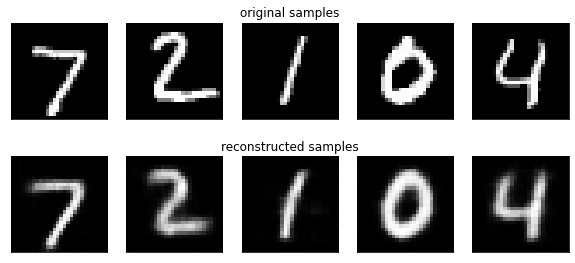

batch loss in training:	  8239.331055
batch loss in training:	  8300.729492
batch loss in training:	  8420.574219
batch loss in training:	  8272.353516
batch loss in training:	  8316.799805
batch loss in training:	  8227.278320
batch loss in training:	  8605.500000
batch loss in training:	  8214.571289
batch loss in training:	  8265.956055
batch loss in training:	  8200.900391
batch loss in training:	  8119.135254
batch loss in training:	  8144.447266
batch loss in training:	  8295.535156
batch loss in training:	  8145.437012
batch loss in training:	  8335.154297
batch loss in training:	  8366.046875
batch loss in training:	  8022.377930
batch loss in training:	  7943.321289
batch loss in training:	  8154.928711
batch loss in training:	  8411.744141
batch loss in training:	  7646.541992
batch loss in training:	  8629.408203
batch loss in training:	  8583.624023
batch loss in training:	  8137.941406
batch loss in training:	  8178.725586
batch loss in training:	  8438.853516
batch loss i

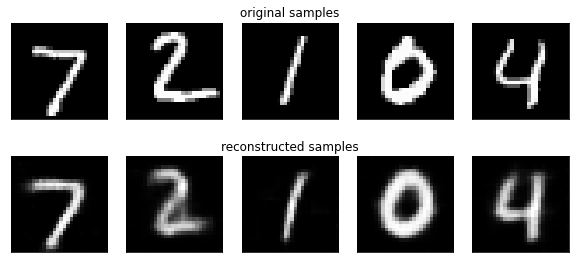

batch loss in training:	  8242.204102
batch loss in training:	  8311.513672
batch loss in training:	  8413.548828
batch loss in training:	  8256.451172
batch loss in training:	  8248.570312
batch loss in training:	  8282.193359
batch loss in training:	  8566.254883
batch loss in training:	  8166.687012
batch loss in training:	  8232.023438
batch loss in training:	  8235.275391
batch loss in training:	  8101.115234
batch loss in training:	  8128.900391
batch loss in training:	  8266.724609
batch loss in training:	  8181.635254
batch loss in training:	  8319.562500
batch loss in training:	  8311.432617
batch loss in training:	  8029.383789
batch loss in training:	  8000.302734
batch loss in training:	  8123.600586
batch loss in training:	  8380.397461
batch loss in training:	  7629.259766
batch loss in training:	  8605.970703
batch loss in training:	  8595.450195
batch loss in training:	  8181.382812
batch loss in training:	  8169.062500
batch loss in training:	  8429.543945
batch loss i

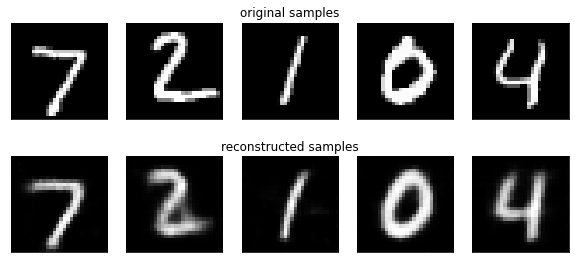

batch loss in training:	  8243.803711
batch loss in training:	  8307.471680
batch loss in training:	  8469.574219
batch loss in training:	  8289.139648
batch loss in training:	  8269.089844
batch loss in training:	  8225.913086
batch loss in training:	  8570.442383
batch loss in training:	  8101.882324
batch loss in training:	  8251.405273
batch loss in training:	  8304.637695
batch loss in training:	  8136.871094
batch loss in training:	  8113.967285
batch loss in training:	  8364.575195
batch loss in training:	  8121.127441
batch loss in training:	  8325.988281
batch loss in training:	  8365.662109
batch loss in training:	  7964.692383
batch loss in training:	  7960.503906
batch loss in training:	  8149.878906
batch loss in training:	  8348.770508
batch loss in training:	  7594.298828
batch loss in training:	  8614.046875
batch loss in training:	  8547.166016
batch loss in training:	  8135.041992
batch loss in training:	  8179.888672
batch loss in training:	  8422.851562
batch loss i

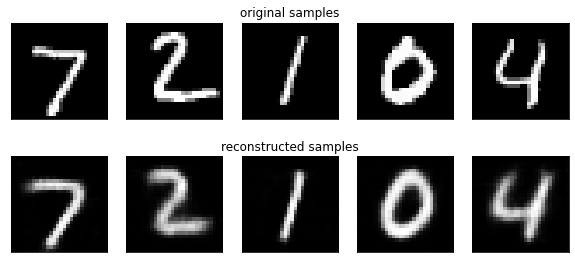

batch loss in training:	  8171.843750
batch loss in training:	  8276.279297
batch loss in training:	  8468.953125
batch loss in training:	  8156.213379
batch loss in training:	  8251.640625
batch loss in training:	  8282.761719
batch loss in training:	  8571.142578
batch loss in training:	  8157.598633
batch loss in training:	  8239.132812
batch loss in training:	  8306.443359
batch loss in training:	  8135.677734
batch loss in training:	  8187.244629
batch loss in training:	  8240.214844
batch loss in training:	  8157.274902
batch loss in training:	  8376.417969
batch loss in training:	  8354.817383
batch loss in training:	  7995.791504
batch loss in training:	  7920.779297
batch loss in training:	  8097.066406
batch loss in training:	  8461.245117
batch loss in training:	  7659.038086
batch loss in training:	  8499.306641
batch loss in training:	  8621.300781
batch loss in training:	  8106.957520
batch loss in training:	  8282.916016
batch loss in training:	  8438.152344
batch loss i

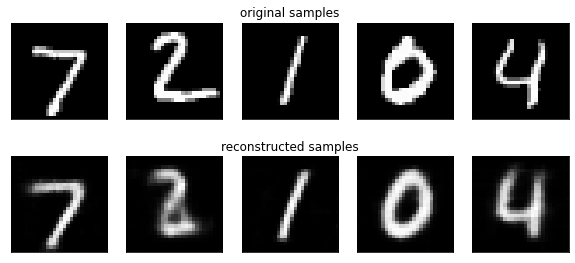

batch loss in training:	  8123.936523
batch loss in training:	  8323.879883
batch loss in training:	  8397.561523
batch loss in training:	  8206.518555
batch loss in training:	  8245.093750
batch loss in training:	  8294.998047
batch loss in training:	  8633.238281
batch loss in training:	  8121.026367
batch loss in training:	  8272.782227
batch loss in training:	  8170.569824
batch loss in training:	  8218.636719
batch loss in training:	  8171.446289
batch loss in training:	  8246.244141
batch loss in training:	  8108.290039
batch loss in training:	  8405.179688
batch loss in training:	  8236.436523
batch loss in training:	  8010.737305
batch loss in training:	  7863.553711
batch loss in training:	  8095.559570
batch loss in training:	  8362.572266
batch loss in training:	  7716.893066
batch loss in training:	  8532.942383
batch loss in training:	  8494.767578
batch loss in training:	  8140.708984
batch loss in training:	  8180.472656
batch loss in training:	  8359.443359
batch loss i

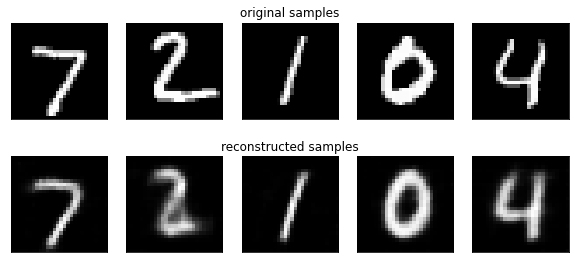

batch loss in training:	  8096.431641
batch loss in training:	  8305.768555
batch loss in training:	  8387.873047
batch loss in training:	  8312.457031
batch loss in training:	  8252.446289
batch loss in training:	  8189.994141
batch loss in training:	  8603.624023
batch loss in training:	  8177.965332
batch loss in training:	  8232.103516
batch loss in training:	  8199.621094
batch loss in training:	  8119.602539
batch loss in training:	  8101.535645
batch loss in training:	  8238.968750
batch loss in training:	  8237.284180
batch loss in training:	  8378.570312
batch loss in training:	  8304.080078
batch loss in training:	  8051.020996
batch loss in training:	  7917.653320
batch loss in training:	  8074.139648
batch loss in training:	  8333.042969
batch loss in training:	  7625.134277
batch loss in training:	  8537.257812
batch loss in training:	  8573.058594
batch loss in training:	  8189.062988
batch loss in training:	  8173.234863
batch loss in training:	  8366.923828
batch loss i

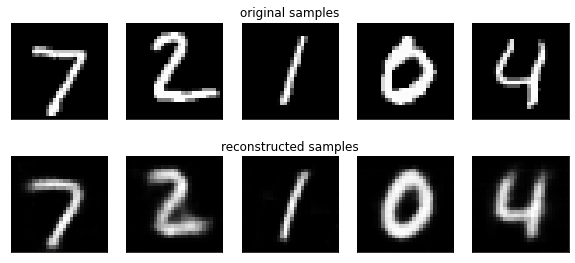

batch loss in training:	  8071.748047
batch loss in training:	  8249.303711
batch loss in training:	  8371.333008
batch loss in training:	  8122.819824
batch loss in training:	  8204.600586
batch loss in training:	  8211.675781
batch loss in training:	  8623.590820
batch loss in training:	  8147.017578
batch loss in training:	  8215.733398
batch loss in training:	  8140.202637
batch loss in training:	  8111.088867
batch loss in training:	  8189.432617
batch loss in training:	  8223.474609
batch loss in training:	  8193.210938
batch loss in training:	  8361.890625
batch loss in training:	  8264.443359
batch loss in training:	  7971.600586
batch loss in training:	  7869.606445
batch loss in training:	  8007.857422
batch loss in training:	  8371.205078
batch loss in training:	  7605.133789
batch loss in training:	  8539.279297
batch loss in training:	  8504.929688
batch loss in training:	  8107.523926
batch loss in training:	  8134.289062
batch loss in training:	  8341.127930
batch loss i

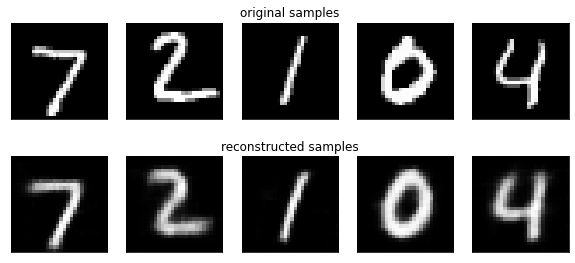

batch loss in training:	  8188.467773
batch loss in training:	  8320.764648
batch loss in training:	  8385.444336
batch loss in training:	  8226.054688
batch loss in training:	  8245.509766
batch loss in training:	  8245.539062
batch loss in training:	  8490.091797
batch loss in training:	  8086.110840
batch loss in training:	  8220.363281
batch loss in training:	  8130.604980
batch loss in training:	  8103.324219
batch loss in training:	  8181.264648
batch loss in training:	  8247.251953
batch loss in training:	  8137.197266
batch loss in training:	  8385.887695
batch loss in training:	  8293.050781
batch loss in training:	  7896.235352
batch loss in training:	  7980.648438
batch loss in training:	  8082.378906
batch loss in training:	  8384.229492
batch loss in training:	  7588.916504
batch loss in training:	  8517.037109
batch loss in training:	  8497.694336
batch loss in training:	  8096.378906
batch loss in training:	  8153.882812
batch loss in training:	  8400.812500
batch loss i

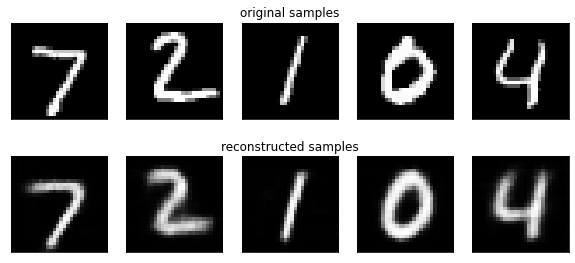

batch loss in training:	  8083.415039
batch loss in training:	  8264.353516
batch loss in training:	  8354.828125
batch loss in training:	  8205.407227
batch loss in training:	  8241.785156
batch loss in training:	  8187.558105
batch loss in training:	  8579.540039
batch loss in training:	  8136.203125
batch loss in training:	  8224.126953
batch loss in training:	  8130.155273
batch loss in training:	  8175.816406
batch loss in training:	  8078.558594
batch loss in training:	  8266.390625
batch loss in training:	  8148.977051
batch loss in training:	  8285.783203
batch loss in training:	  8238.166992
batch loss in training:	  7887.943848
batch loss in training:	  7906.685059
batch loss in training:	  8038.518555
batch loss in training:	  8314.830078
batch loss in training:	  7553.415039
batch loss in training:	  8571.166992
batch loss in training:	  8531.591797
batch loss in training:	  8136.605469
batch loss in training:	  8239.988281
batch loss in training:	  8429.538086
batch loss i

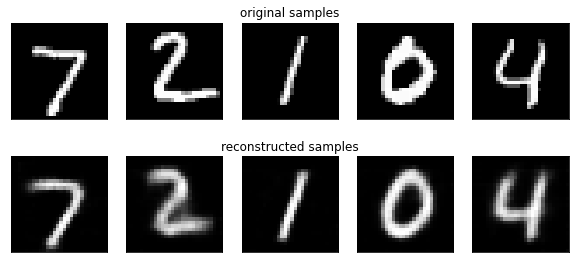

batch loss in training:	  8114.785156
batch loss in training:	  8260.021484
batch loss in training:	  8354.114258
batch loss in training:	  8181.724609
batch loss in training:	  8148.109863
batch loss in training:	  8219.529297
batch loss in training:	  8594.132812
batch loss in training:	  8221.778320
batch loss in training:	  8229.356445
batch loss in training:	  8164.617676
batch loss in training:	  8026.629883
batch loss in training:	  8137.827637
batch loss in training:	  8251.878906
batch loss in training:	  8104.539062
batch loss in training:	  8333.516602
batch loss in training:	  8201.896484
batch loss in training:	  8037.172852
batch loss in training:	  7849.409180
batch loss in training:	  8023.300293
batch loss in training:	  8313.000000
batch loss in training:	  7565.552246
batch loss in training:	  8514.021484
batch loss in training:	  8526.818359
batch loss in training:	  8119.113281
batch loss in training:	  8175.548340
batch loss in training:	  8343.416016
batch loss i

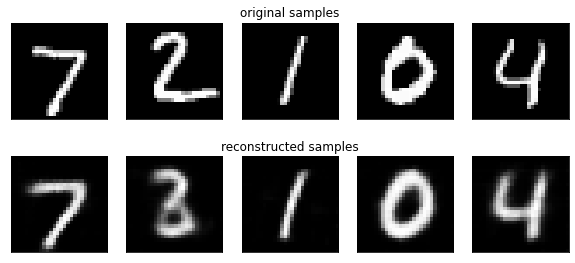

batch loss in training:	  8124.683105
batch loss in training:	  8215.197266
batch loss in training:	  8371.412109
batch loss in training:	  8203.693359
batch loss in training:	  8198.722656
batch loss in training:	  8276.250977
batch loss in training:	  8536.349609
batch loss in training:	  8159.570312
batch loss in training:	  8162.258789
batch loss in training:	  8141.101074
batch loss in training:	  8082.934570
batch loss in training:	  8116.745117
batch loss in training:	  8256.537109
batch loss in training:	  8090.242188
batch loss in training:	  8278.556641
batch loss in training:	  8254.648438
batch loss in training:	  7928.834961
batch loss in training:	  7891.907227
batch loss in training:	  8058.532227
batch loss in training:	  8304.738281
batch loss in training:	  7569.654297
batch loss in training:	  8532.500000
batch loss in training:	  8462.415039
batch loss in training:	  8159.685059
batch loss in training:	  8127.025879
batch loss in training:	  8342.109375
batch loss i

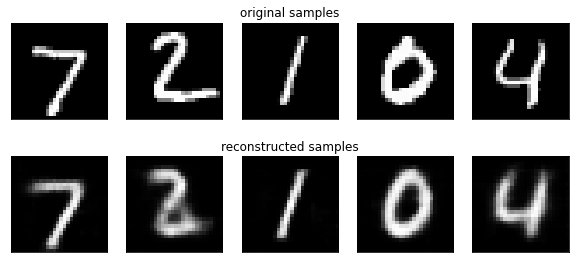

batch loss in training:	  8063.096680
batch loss in training:	  8293.968750
batch loss in training:	  8412.805664
batch loss in training:	  8270.711914
batch loss in training:	  8234.427734
batch loss in training:	  8187.980469
batch loss in training:	  8611.051758
batch loss in training:	  8155.934570
batch loss in training:	  8226.353516
batch loss in training:	  8236.907227
batch loss in training:	  8104.302734
batch loss in training:	  8171.644531
batch loss in training:	  8269.888672
batch loss in training:	  8115.044922
batch loss in training:	  8335.367188
batch loss in training:	  8265.041992
batch loss in training:	  7904.625488
batch loss in training:	  7824.377930
batch loss in training:	  8024.316406
batch loss in training:	  8318.375000
batch loss in training:	  7587.662109
batch loss in training:	  8527.152344
batch loss in training:	  8503.015625
batch loss in training:	  8119.431641
batch loss in training:	  8098.130859
batch loss in training:	  8355.814453
batch loss i

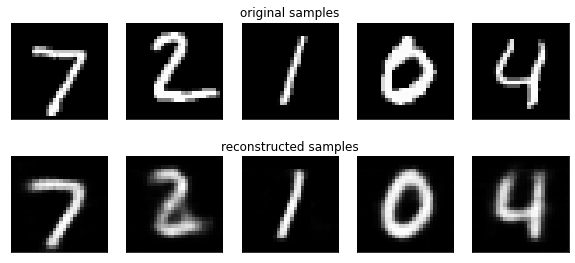

batch loss in training:	  8144.132812
batch loss in training:	  8217.800781
batch loss in training:	  8344.958984
batch loss in training:	  8251.437500
batch loss in training:	  8212.983398
batch loss in training:	  8152.097168
batch loss in training:	  8543.441406
batch loss in training:	  8131.304199
batch loss in training:	  8285.463867
batch loss in training:	  8158.530762
batch loss in training:	  8007.109863
batch loss in training:	  8098.098145
batch loss in training:	  8316.857422
batch loss in training:	  8101.608398
batch loss in training:	  8257.104492
batch loss in training:	  8237.720703
batch loss in training:	  7920.854492
batch loss in training:	  7929.172363
batch loss in training:	  8015.505371
batch loss in training:	  8330.670898
batch loss in training:	  7492.509766
batch loss in training:	  8524.054688
batch loss in training:	  8501.679688
batch loss in training:	  8053.792480
batch loss in training:	  8159.209961
batch loss in training:	  8364.187500
batch loss i

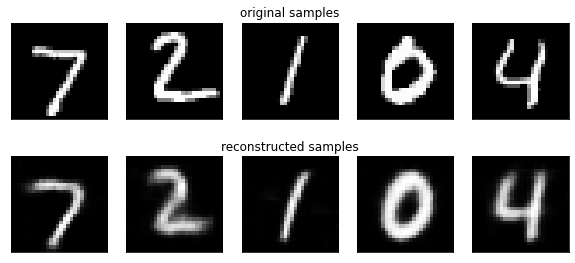

batch loss in training:	  8091.701172
batch loss in training:	  8285.579102
batch loss in training:	  8326.440430
batch loss in training:	  8230.356445
batch loss in training:	  8222.140625
batch loss in training:	  8230.707031
batch loss in training:	  8502.340820
batch loss in training:	  8112.593750
batch loss in training:	  8301.363281
batch loss in training:	  8163.705078
batch loss in training:	  8071.238281
batch loss in training:	  8141.847656
batch loss in training:	  8261.347656
batch loss in training:	  8148.599609
batch loss in training:	  8277.153320
batch loss in training:	  8186.811523
batch loss in training:	  7935.035156
batch loss in training:	  7886.541016
batch loss in training:	  8098.722656
batch loss in training:	  8360.535156
batch loss in training:	  7589.587402
batch loss in training:	  8532.337891
batch loss in training:	  8522.709961
batch loss in training:	  8107.853516
batch loss in training:	  8149.229004
batch loss in training:	  8264.263672
batch loss i

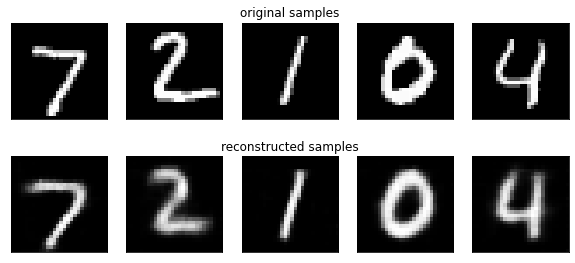

batch loss in training:	  8154.328125
batch loss in training:	  8263.755859
batch loss in training:	  8317.605469
batch loss in training:	  8130.869141
batch loss in training:	  8203.359375
batch loss in training:	  8224.226562
batch loss in training:	  8510.460938
batch loss in training:	  8101.899414
batch loss in training:	  8186.664551
batch loss in training:	  8179.071289
batch loss in training:	  8108.520508
batch loss in training:	  8082.170410
batch loss in training:	  8139.128906
batch loss in training:	  8104.380859
batch loss in training:	  8312.800781
batch loss in training:	  8192.732422
batch loss in training:	  7895.897461
batch loss in training:	  7898.746094
batch loss in training:	  8043.486328
batch loss in training:	  8326.113281
batch loss in training:	  7571.690918
batch loss in training:	  8480.923828
batch loss in training:	  8506.983398
batch loss in training:	  8032.887695
batch loss in training:	  8146.495605
batch loss in training:	  8298.599609
batch loss i

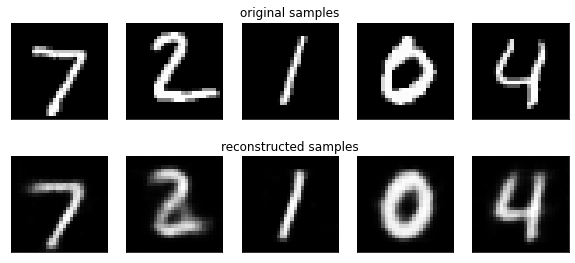

batch loss in training:	  8105.167480
batch loss in training:	  8211.922852
batch loss in training:	  8320.620117
batch loss in training:	  8184.972168
batch loss in training:	  8268.675781
batch loss in training:	  8280.390625
batch loss in training:	  8632.157227
batch loss in training:	  8126.115234
batch loss in training:	  8173.074219
batch loss in training:	  8189.694824
batch loss in training:	  8076.261719
batch loss in training:	  8147.448242
batch loss in training:	  8243.953125
batch loss in training:	  8214.941406
batch loss in training:	  8339.201172
batch loss in training:	  8170.488281
batch loss in training:	  7928.785645
batch loss in training:	  7897.286621
batch loss in training:	  8073.985352
batch loss in training:	  8321.505859
batch loss in training:	  7515.604004
batch loss in training:	  8536.410156
batch loss in training:	  8409.517578
batch loss in training:	  8040.128906
batch loss in training:	  8105.971680
batch loss in training:	  8274.933594
batch loss i

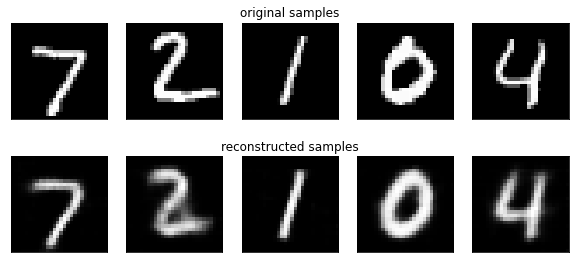

batch loss in training:	  8109.358887
batch loss in training:	  8180.586914
batch loss in training:	  8338.194336
batch loss in training:	  8125.387695
batch loss in training:	  8141.448242
batch loss in training:	  8260.853516
batch loss in training:	  8458.375000
batch loss in training:	  8110.024414
batch loss in training:	  8216.511719
batch loss in training:	  8094.283203
batch loss in training:	  8043.971191
batch loss in training:	  8009.793457
batch loss in training:	  8206.636719
batch loss in training:	  8121.909180
batch loss in training:	  8297.008789
batch loss in training:	  8162.559570
batch loss in training:	  7990.296875
batch loss in training:	  7878.395996
batch loss in training:	  7988.510742
batch loss in training:	  8345.011719
batch loss in training:	  7559.311035
batch loss in training:	  8502.587891
batch loss in training:	  8476.957031
batch loss in training:	  8057.174805
batch loss in training:	  8082.098633
batch loss in training:	  8424.819336
batch loss i

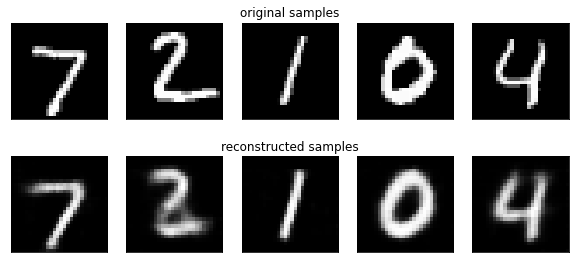

batch loss in training:	  8068.572266
batch loss in training:	  8240.857422
batch loss in training:	  8326.672852
batch loss in training:	  8197.750000
batch loss in training:	  8164.632324
batch loss in training:	  8216.803711
batch loss in training:	  8500.374023
batch loss in training:	  8077.833008
batch loss in training:	  8151.878906
batch loss in training:	  8189.868164
batch loss in training:	  8083.157227
batch loss in training:	  8090.015625
batch loss in training:	  8255.515625
batch loss in training:	  8171.665039
batch loss in training:	  8301.442383
batch loss in training:	  8126.096680
batch loss in training:	  7910.537109
batch loss in training:	  7857.922852
batch loss in training:	  8049.694336
batch loss in training:	  8343.193359
batch loss in training:	  7513.325195
batch loss in training:	  8520.268555
batch loss in training:	  8425.763672
batch loss in training:	  8035.990234
batch loss in training:	  8078.756836
batch loss in training:	  8260.839844
batch loss i

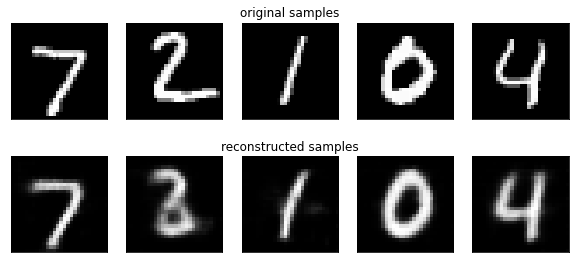

batch loss in training:	  8066.643066
batch loss in training:	  8175.970215
batch loss in training:	  8359.725586
batch loss in training:	  8117.271973
batch loss in training:	  8172.934570
batch loss in training:	  8119.200195
batch loss in training:	  8517.146484
batch loss in training:	  8051.951172
batch loss in training:	  8200.086914
batch loss in training:	  8166.252441
batch loss in training:	  7989.256836
batch loss in training:	  8082.820312
batch loss in training:	  8171.391602
batch loss in training:	  8186.561035
batch loss in training:	  8248.408203
batch loss in training:	  8240.076172
batch loss in training:	  7953.610352
batch loss in training:	  7860.779785
batch loss in training:	  8000.941406
batch loss in training:	  8313.828125
batch loss in training:	  7571.666016
batch loss in training:	  8454.691406
batch loss in training:	  8449.478516
batch loss in training:	  8071.669922
batch loss in training:	  8151.681641
batch loss in training:	  8336.457031
batch loss i

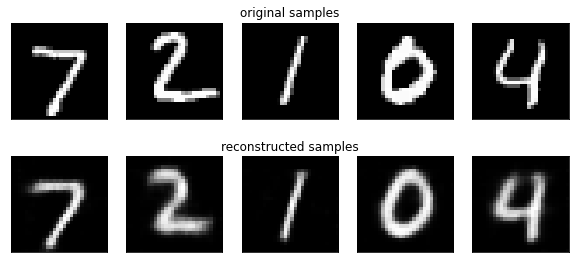

batch loss in training:	  8050.984863
batch loss in training:	  8193.382812
batch loss in training:	  8303.264648
batch loss in training:	  8146.775879
batch loss in training:	  8221.679688
batch loss in training:	  8150.471680
batch loss in training:	  8482.655273
batch loss in training:	  8133.878906
batch loss in training:	  8146.475098
batch loss in training:	  8039.681152
batch loss in training:	  8000.861816
batch loss in training:	  8093.738770
batch loss in training:	  8201.253906
batch loss in training:	  8123.528320
batch loss in training:	  8345.364258
batch loss in training:	  8182.850586
batch loss in training:	  7862.891602
batch loss in training:	  7813.105469
batch loss in training:	  8020.953613
batch loss in training:	  8327.044922
batch loss in training:	  7527.083008
batch loss in training:	  8447.060547
batch loss in training:	  8486.623047
batch loss in training:	  8099.750977
batch loss in training:	  8073.818359
batch loss in training:	  8329.376953
batch loss i

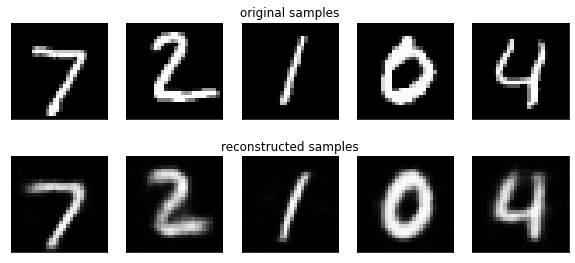

batch loss in training:	  8075.434082
batch loss in training:	  8186.616211
batch loss in training:	  8276.844727
batch loss in training:	  8126.321289
batch loss in training:	  8201.097656
batch loss in training:	  8154.352539
batch loss in training:	  8511.156250
batch loss in training:	  8065.798828
batch loss in training:	  8146.111328
batch loss in training:	  8122.734863
batch loss in training:	  8016.866211
batch loss in training:	  8051.708008
batch loss in training:	  8183.928223
batch loss in training:	  8129.648926
batch loss in training:	  8297.847656
batch loss in training:	  8206.837891
batch loss in training:	  7920.404297
batch loss in training:	  7857.956055
batch loss in training:	  8005.637695
batch loss in training:	  8319.937500
batch loss in training:	  7486.830078
batch loss in training:	  8507.879883
batch loss in training:	  8482.880859
batch loss in training:	  8078.100098
batch loss in training:	  8077.290039
batch loss in training:	  8353.081055
batch loss i

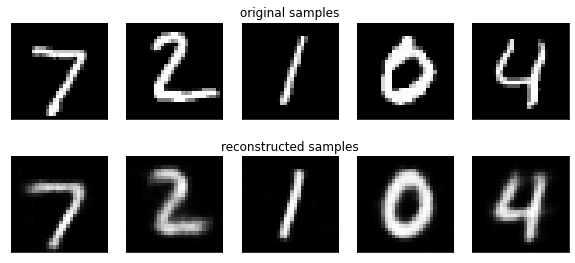

batch loss in training:	  8055.322754
batch loss in training:	  8230.799805
batch loss in training:	  8237.438477
batch loss in training:	  8183.446289
batch loss in training:	  8183.146973
batch loss in training:	  8139.116211
batch loss in training:	  8398.350586
batch loss in training:	  8006.226562
batch loss in training:	  8088.202637
batch loss in training:	  8123.847168
batch loss in training:	  8034.390625
batch loss in training:	  8125.083008
batch loss in training:	  8218.062500
batch loss in training:	  8147.008789
batch loss in training:	  8194.550781
batch loss in training:	  8106.112305
batch loss in training:	  7961.130371
batch loss in training:	  7798.978516
batch loss in training:	  7957.936035
batch loss in training:	  8255.501953
batch loss in training:	  7455.773438
batch loss in training:	  8456.710938
batch loss in training:	  8510.718750
batch loss in training:	  8117.538086
batch loss in training:	  8104.213867
batch loss in training:	  8308.021484
batch loss i

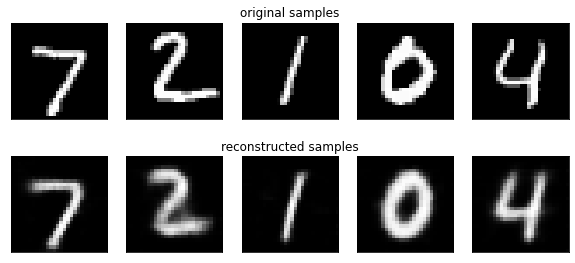

batch loss in training:	  8178.277344
batch loss in training:	  8212.070312
batch loss in training:	  8276.240234
batch loss in training:	  8223.982422
batch loss in training:	  8240.316406
batch loss in training:	  8200.869141
batch loss in training:	  8503.321289
batch loss in training:	  8032.649902
batch loss in training:	  8179.722656
batch loss in training:	  8086.445312
batch loss in training:	  8015.890137
batch loss in training:	  8050.170410
batch loss in training:	  8218.568359
batch loss in training:	  8130.788086
batch loss in training:	  8257.958008
batch loss in training:	  8237.848633
batch loss in training:	  7927.817871
batch loss in training:	  7820.792480
batch loss in training:	  8014.123047
batch loss in training:	  8247.367188
batch loss in training:	  7509.191406
batch loss in training:	  8453.310547
batch loss in training:	  8407.189453
batch loss in training:	  7983.853516
batch loss in training:	  8071.194336
batch loss in training:	  8258.603516
batch loss i

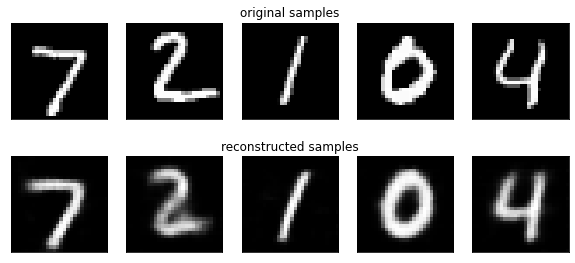

batch loss in training:	  8080.173828
batch loss in training:	  8099.948242
batch loss in training:	  8237.671875
batch loss in training:	  8155.702148
batch loss in training:	  8215.465820
batch loss in training:	  8175.442383
batch loss in training:	  8559.397461
batch loss in training:	  8029.395996
batch loss in training:	  8166.314941
batch loss in training:	  8068.031250
batch loss in training:	  8048.784668
batch loss in training:	  8117.607422
batch loss in training:	  8192.308594
batch loss in training:	  8088.718750
batch loss in training:	  8243.175781
batch loss in training:	  8310.876953
batch loss in training:	  7929.275391
batch loss in training:	  7746.625488
batch loss in training:	  7999.547852
batch loss in training:	  8288.697266
batch loss in training:	  7548.371582
batch loss in training:	  8524.682617
batch loss in training:	  8400.546875
batch loss in training:	  8048.193359
batch loss in training:	  8098.116699
batch loss in training:	  8303.303711
batch loss i

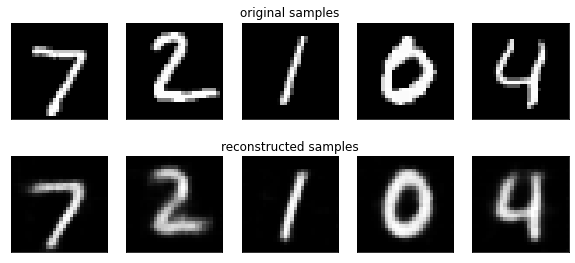

batch loss in training:	  8101.662109
batch loss in training:	  8144.790039
batch loss in training:	  8238.350586
batch loss in training:	  8103.537109
batch loss in training:	  8124.880859
batch loss in training:	  8183.975586
batch loss in training:	  8454.827148
batch loss in training:	  8135.632812
batch loss in training:	  8173.860840
batch loss in training:	  8075.577148
batch loss in training:	  7978.794434
batch loss in training:	  8098.830078
batch loss in training:	  8160.893555
batch loss in training:	  8059.721191
batch loss in training:	  8308.195312
batch loss in training:	  8155.781250
batch loss in training:	  7825.648926
batch loss in training:	  7842.565430
batch loss in training:	  8011.662109
batch loss in training:	  8272.039062
batch loss in training:	  7481.782227
batch loss in training:	  8449.095703
batch loss in training:	  8389.619141
batch loss in training:	  8039.192383
batch loss in training:	  8113.312988
batch loss in training:	  8306.371094
batch loss i

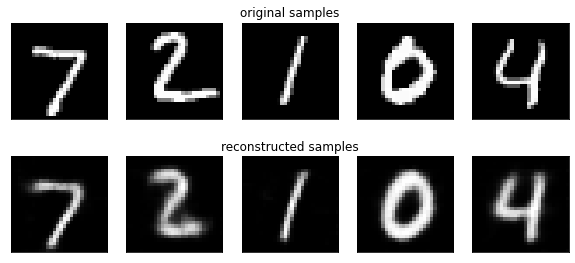

batch loss in training:	  8072.916016
batch loss in training:	  8181.950195
batch loss in training:	  8259.223633
batch loss in training:	  8193.965820
batch loss in training:	  8226.173828
batch loss in training:	  8121.661621
batch loss in training:	  8446.556641
batch loss in training:	  7980.561523
batch loss in training:	  8169.255859
batch loss in training:	  8211.972656
batch loss in training:	  8057.096680
batch loss in training:	  8051.602051
batch loss in training:	  8129.940430
batch loss in training:	  8090.138672
batch loss in training:	  8235.346680
batch loss in training:	  8144.502930
batch loss in training:	  7937.585938
batch loss in training:	  7764.851562
batch loss in training:	  7998.664062
batch loss in training:	  8281.058594
batch loss in training:	  7535.537109
batch loss in training:	  8415.691406
batch loss in training:	  8363.283203
batch loss in training:	  8116.964844
batch loss in training:	  8105.944824
batch loss in training:	  8270.262695
batch loss i

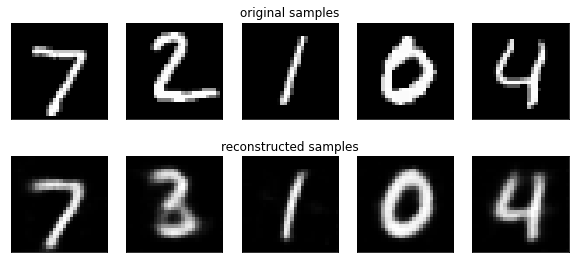

batch loss in training:	  8018.689941
batch loss in training:	  8166.615234
batch loss in training:	  8311.906250
batch loss in training:	  8111.631836
batch loss in training:	  8154.592773
batch loss in training:	  8156.918457
batch loss in training:	  8412.863281
batch loss in training:	  8027.376953
batch loss in training:	  8175.159668
batch loss in training:	  8011.135742
batch loss in training:	  7958.010742
batch loss in training:	  7967.046875
batch loss in training:	  8164.572266
batch loss in training:	  8092.899414
batch loss in training:	  8229.787109
batch loss in training:	  8143.245117
batch loss in training:	  7899.084473
batch loss in training:	  7845.826172
batch loss in training:	  8040.128906
batch loss in training:	  8252.609375
batch loss in training:	  7459.876465
batch loss in training:	  8428.673828
batch loss in training:	  8415.884766
batch loss in training:	  8036.888184
batch loss in training:	  8040.572754
batch loss in training:	  8315.150391
batch loss i

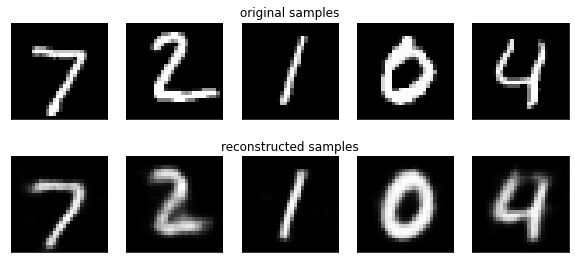

batch loss in training:	  8053.504395
batch loss in training:	  8173.493164
batch loss in training:	  8290.802734
batch loss in training:	  8126.167969
batch loss in training:	  8103.335938
batch loss in training:	  8167.710449
batch loss in training:	  8466.058594
batch loss in training:	  7945.427734
batch loss in training:	  8166.544434
batch loss in training:	  8025.616699
batch loss in training:	  7998.059570
batch loss in training:	  8005.901367
batch loss in training:	  8130.300781
batch loss in training:	  8025.250977
batch loss in training:	  8192.786133
batch loss in training:	  8155.534180
batch loss in training:	  7906.515625
batch loss in training:	  7869.993164
batch loss in training:	  7986.868164
batch loss in training:	  8293.244141
batch loss in training:	  7536.778809
batch loss in training:	  8450.373047
batch loss in training:	  8421.808594
batch loss in training:	  8039.098145
batch loss in training:	  8058.413574
batch loss in training:	  8297.025391
batch loss i

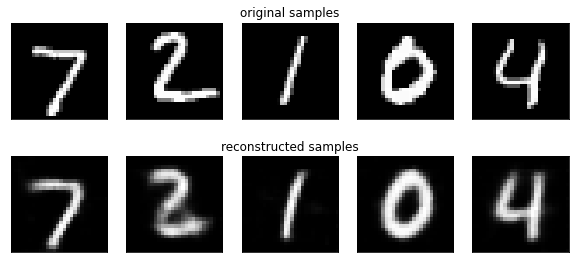

batch loss in training:	  8038.036621
batch loss in training:	  8068.720703
batch loss in training:	  8297.785156
batch loss in training:	  8137.461914
batch loss in training:	  8211.973633
batch loss in training:	  8162.031738
batch loss in training:	  8468.333984
batch loss in training:	  7968.744629
batch loss in training:	  8161.229492
batch loss in training:	  8042.031250
batch loss in training:	  7996.640625
batch loss in training:	  8025.974609
batch loss in training:	  8121.317383
batch loss in training:	  8150.506836
batch loss in training:	  8219.603516
batch loss in training:	  8137.144043
batch loss in training:	  7833.937988
batch loss in training:	  7820.352539
batch loss in training:	  7974.714844
batch loss in training:	  8313.384766
batch loss in training:	  7514.508301
batch loss in training:	  8444.347656
batch loss in training:	  8425.398438
batch loss in training:	  8040.464844
batch loss in training:	  8054.550293
batch loss in training:	  8243.780273
batch loss i

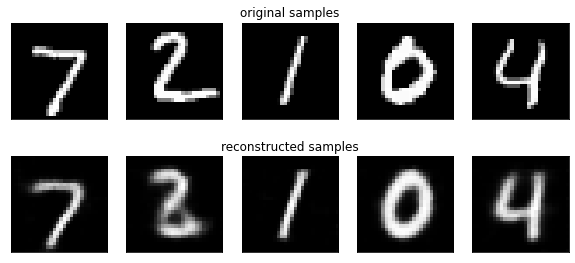

batch loss in training:	  8022.776367
batch loss in training:	  8154.937012
batch loss in training:	  8254.078125
batch loss in training:	  8125.736816
batch loss in training:	  8240.332031
batch loss in training:	  8156.815918
batch loss in training:	  8414.109375
batch loss in training:	  8012.501465
batch loss in training:	  8161.615723
batch loss in training:	  8124.826660
batch loss in training:	  7980.376465
batch loss in training:	  8036.186035
batch loss in training:	  8138.330566
batch loss in training:	  8146.991211
batch loss in training:	  8267.789062
batch loss in training:	  8115.427734
batch loss in training:	  7832.862793
batch loss in training:	  7810.125000
batch loss in training:	  7945.978027
batch loss in training:	  8221.716797
batch loss in training:	  7491.887695
batch loss in training:	  8420.786133
batch loss in training:	  8382.058594
batch loss in training:	  8030.536133
batch loss in training:	  8016.413574
batch loss in training:	  8276.697266
batch loss i

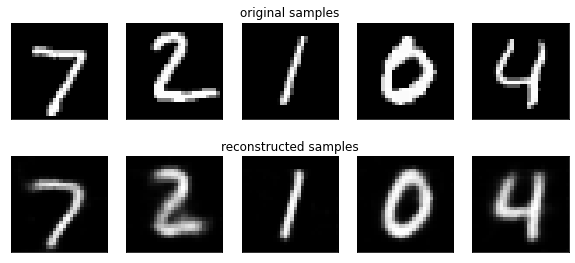

batch loss in training:	  8017.853516
batch loss in training:	  8143.999512
batch loss in training:	  8230.079102
batch loss in training:	  8102.488770
batch loss in training:	  8116.669434
batch loss in training:	  8127.748535
batch loss in training:	  8456.826172
batch loss in training:	  8043.080078
batch loss in training:	  8099.486328
batch loss in training:	  8026.148438
batch loss in training:	  7968.461914
batch loss in training:	  7964.868652
batch loss in training:	  8116.229980
batch loss in training:	  8089.418945
batch loss in training:	  8130.413086
batch loss in training:	  8121.796387
batch loss in training:	  7926.016113
batch loss in training:	  7874.298828
batch loss in training:	  7927.720703
batch loss in training:	  8359.457031
batch loss in training:	  7523.175781
batch loss in training:	  8464.115234
batch loss in training:	  8411.716797
batch loss in training:	  8000.128906
batch loss in training:	  8045.337891
batch loss in training:	  8253.851562
batch loss i

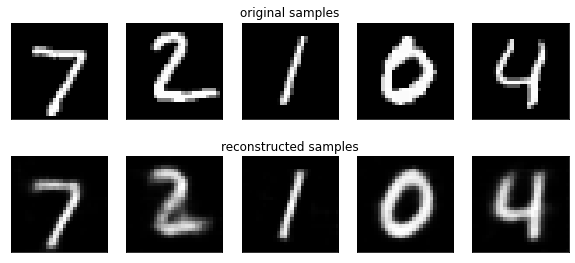

batch loss in training:	  8112.379395
batch loss in training:	  8153.917480
batch loss in training:	  8233.669922
batch loss in training:	  8163.426758
batch loss in training:	  8149.213867
batch loss in training:	  8137.921875
batch loss in training:	  8538.242188
batch loss in training:	  7962.283203
batch loss in training:	  8127.612305
batch loss in training:	  8076.800781
batch loss in training:	  8069.593750
batch loss in training:	  7966.072266
batch loss in training:	  8059.694336
batch loss in training:	  8063.393555
batch loss in training:	  8282.518555
batch loss in training:	  8144.257812
batch loss in training:	  7922.444824
batch loss in training:	  7824.900879
batch loss in training:	  7978.070801
batch loss in training:	  8340.632812
batch loss in training:	  7557.277344
batch loss in training:	  8491.578125
batch loss in training:	  8375.466797
batch loss in training:	  8037.314453
batch loss in training:	  7964.354004
batch loss in training:	  8309.724609
batch loss i

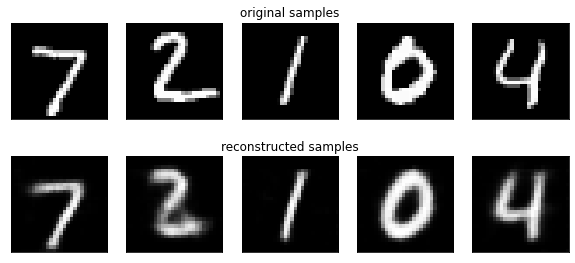

batch loss in training:	  7983.460449
batch loss in training:	  8081.208008
batch loss in training:	  8236.416016
batch loss in training:	  8091.006348
batch loss in training:	  8148.010742
batch loss in training:	  8161.303711
batch loss in training:	  8459.489258
batch loss in training:	  8055.625488
batch loss in training:	  8106.657227
batch loss in training:	  8090.963379
batch loss in training:	  8030.395996
batch loss in training:	  8012.678223
batch loss in training:	  8064.690430
batch loss in training:	  8100.136719
batch loss in training:	  8229.790039
batch loss in training:	  8172.367188
batch loss in training:	  7900.056641
batch loss in training:	  7785.263184
batch loss in training:	  7932.016602
batch loss in training:	  8287.044922
batch loss in training:	  7503.008789
batch loss in training:	  8425.177734
batch loss in training:	  8407.607422
batch loss in training:	  8018.194336
batch loss in training:	  8011.608398
batch loss in training:	  8283.221680
batch loss i

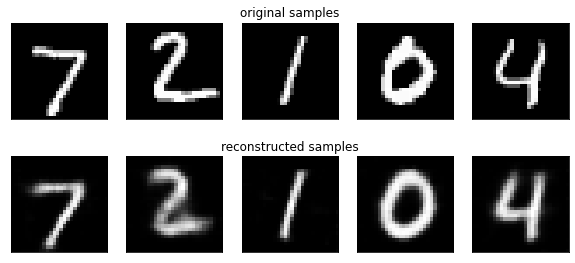

batch loss in training:	  7999.721680
batch loss in training:	  8152.992188
batch loss in training:	  8185.480957
batch loss in training:	  8147.116699
batch loss in training:	  8098.100586
batch loss in training:	  8124.583984
batch loss in training:	  8357.378906
batch loss in training:	  8021.026855
batch loss in training:	  8123.794922
batch loss in training:	  8099.623047
batch loss in training:	  7935.168457
batch loss in training:	  7980.254395
batch loss in training:	  8081.509277
batch loss in training:	  8071.016602
batch loss in training:	  8171.210449
batch loss in training:	  8131.053711
batch loss in training:	  7887.070312
batch loss in training:	  7850.612305
batch loss in training:	  8022.752441
batch loss in training:	  8231.876953
batch loss in training:	  7509.074219
batch loss in training:	  8438.445312
batch loss in training:	  8351.272461
batch loss in training:	  8012.610352
batch loss in training:	  7964.212402
batch loss in training:	  8246.207031
batch loss i

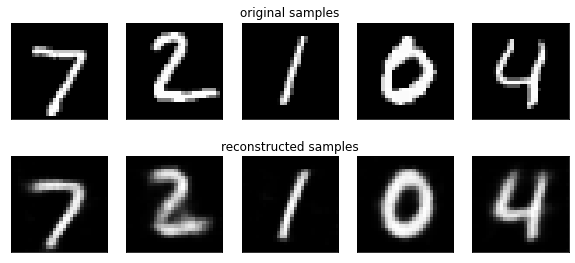

batch loss in training:	  8076.112793
batch loss in training:	  8146.499023
batch loss in training:	  8172.920898
batch loss in training:	  8137.389648
batch loss in training:	  8160.804199
batch loss in training:	  8172.479492
batch loss in training:	  8420.397461
batch loss in training:	  8024.821777
batch loss in training:	  8120.416016
batch loss in training:	  8025.722656
batch loss in training:	  7986.634277
batch loss in training:	  8016.814941
batch loss in training:	  8156.740234
batch loss in training:	  8052.279785
batch loss in training:	  8154.814941
batch loss in training:	  8105.006348
batch loss in training:	  7847.295898
batch loss in training:	  7785.789062
batch loss in training:	  7957.626953
batch loss in training:	  8307.770508
batch loss in training:	  7491.083496
batch loss in training:	  8424.105469
batch loss in training:	  8318.509766
batch loss in training:	  8077.493164
batch loss in training:	  8050.066406
batch loss in training:	  8230.878906
batch loss i

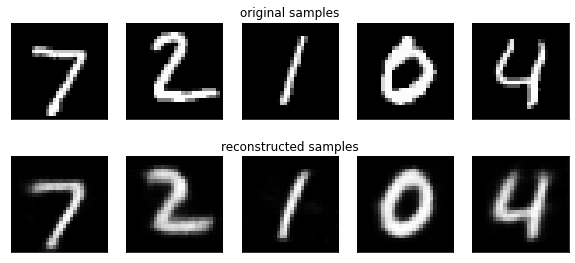

batch loss in training:	  8091.866211
batch loss in training:	  8149.084961
batch loss in training:	  8245.672852
batch loss in training:	  8125.127930
batch loss in training:	  8041.764648
batch loss in training:	  8054.098145
batch loss in training:	  8412.337891
batch loss in training:	  8040.575684
batch loss in training:	  8068.008301
batch loss in training:	  8132.711914
batch loss in training:	  8021.270508
batch loss in training:	  8024.042969
batch loss in training:	  8086.887695
batch loss in training:	  8143.146484
batch loss in training:	  8240.878906
batch loss in training:	  8101.911621
batch loss in training:	  7932.820801
batch loss in training:	  7817.078613
batch loss in training:	  7944.139648
batch loss in training:	  8250.501953
batch loss in training:	  7538.834961
batch loss in training:	  8446.519531
batch loss in training:	  8383.878906
batch loss in training:	  8014.290039
batch loss in training:	  8101.689453
batch loss in training:	  8293.389648
batch loss i

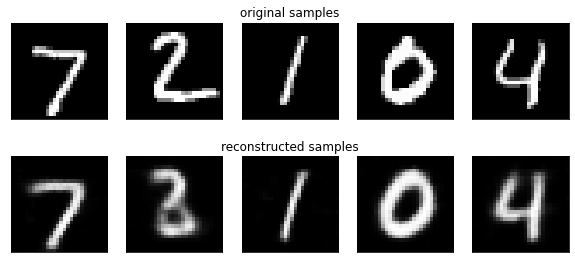

batch loss in training:	  8075.510742
batch loss in training:	  8181.004883
batch loss in training:	  8237.779297
batch loss in training:	  8095.894043
batch loss in training:	  8083.270508
batch loss in training:	  8176.184570
batch loss in training:	  8458.041016
batch loss in training:	  8026.648438
batch loss in training:	  8160.705566
batch loss in training:	  7979.863281
batch loss in training:	  7905.652832
batch loss in training:	  7983.188477
batch loss in training:	  8106.950684
batch loss in training:	  8049.427246
batch loss in training:	  8141.848633
batch loss in training:	  8111.561523
batch loss in training:	  7894.524414
batch loss in training:	  7836.068359
batch loss in training:	  7987.161621
batch loss in training:	  8322.470703
batch loss in training:	  7540.914062
batch loss in training:	  8462.270508
batch loss in training:	  8366.925781
batch loss in training:	  8055.005859
batch loss in training:	  7980.070312
batch loss in training:	  8285.703125
batch loss i

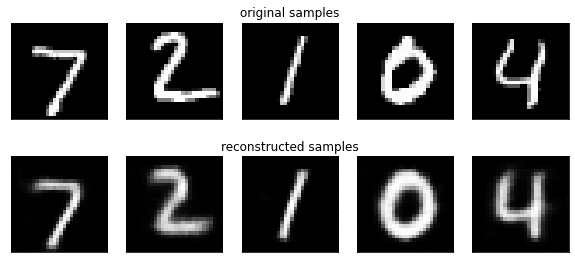

batch loss in training:	  8063.163574
batch loss in training:	  8059.698242
batch loss in training:	  8239.368164
batch loss in training:	  8094.568359
batch loss in training:	  8124.668457
batch loss in training:	  8112.101562
batch loss in training:	  8467.298828
batch loss in training:	  7991.336914
batch loss in training:	  8106.839355
batch loss in training:	  8005.443359
batch loss in training:	  8045.706543
batch loss in training:	  8152.937500
batch loss in training:	  8102.719727
batch loss in training:	  8063.480957
batch loss in training:	  8157.074219
batch loss in training:	  8181.733398
batch loss in training:	  7827.842285
batch loss in training:	  7759.756348
batch loss in training:	  7955.470703
batch loss in training:	  8325.750977
batch loss in training:	  7468.109863
batch loss in training:	  8423.961914
batch loss in training:	  8293.091797
batch loss in training:	  7975.529785
batch loss in training:	  8012.999512
batch loss in training:	  8223.454102
batch loss i

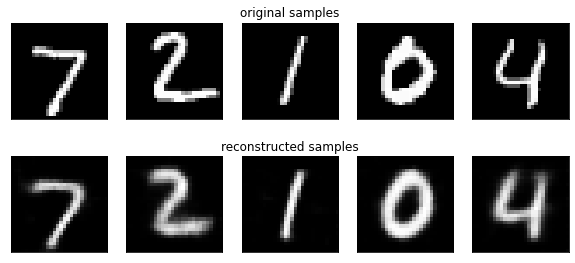

batch loss in training:	  8024.332031
batch loss in training:	  8097.869629
batch loss in training:	  8142.795898
batch loss in training:	  8082.517090
batch loss in training:	  8143.153809
batch loss in training:	  8149.499023
batch loss in training:	  8405.022461
batch loss in training:	  7979.851074
batch loss in training:	  8109.971680
batch loss in training:	  8000.647949
batch loss in training:	  7916.913086
batch loss in training:	  8046.099121
batch loss in training:	  8122.867188
batch loss in training:	  8024.540039
batch loss in training:	  8191.928223
batch loss in training:	  8178.412598
batch loss in training:	  7852.191406
batch loss in training:	  7767.878906
batch loss in training:	  7922.299316
batch loss in training:	  8317.246094
batch loss in training:	  7451.703125
batch loss in training:	  8401.449219
batch loss in training:	  8372.263672
batch loss in training:	  7948.833008
batch loss in training:	  8024.868164
batch loss in training:	  8298.105469
batch loss i

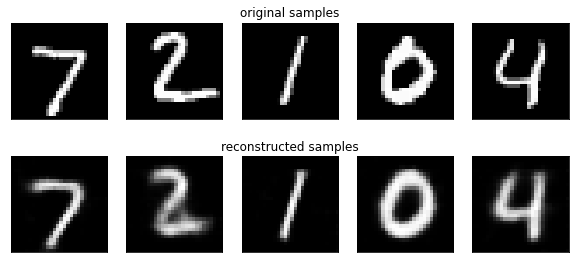

batch loss in training:	  8051.748047
batch loss in training:	  8192.107422
batch loss in training:	  8258.646484
batch loss in training:	  8136.553711
batch loss in training:	  8094.443359
batch loss in training:	  8191.632812
batch loss in training:	  8432.166016
batch loss in training:	  8087.795410
batch loss in training:	  8109.968750
batch loss in training:	  7954.460938
batch loss in training:	  7977.690918
batch loss in training:	  7959.479492
batch loss in training:	  8071.849609
batch loss in training:	  8062.350586
batch loss in training:	  8134.264648
batch loss in training:	  8030.077637
batch loss in training:	  7854.703125
batch loss in training:	  7878.951172
batch loss in training:	  7970.131836
batch loss in training:	  8291.907227
batch loss in training:	  7463.858398
batch loss in training:	  8420.359375
batch loss in training:	  8391.024414
batch loss in training:	  8055.711426
batch loss in training:	  7988.835938
batch loss in training:	  8279.458984
batch loss i

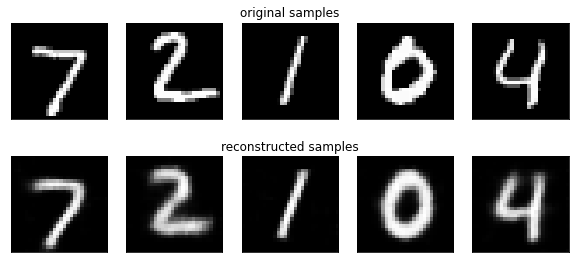

batch loss in training:	  8105.625000
batch loss in training:	  8200.673828
batch loss in training:	  8186.452148
batch loss in training:	  8081.594727
batch loss in training:	  8140.830078
batch loss in training:	  8182.033691
batch loss in training:	  8424.576172
batch loss in training:	  7998.532227
batch loss in training:	  8103.448242
batch loss in training:	  8017.801270
batch loss in training:	  7963.647949
batch loss in training:	  8031.494629
batch loss in training:	  8115.485352
batch loss in training:	  8065.331543
batch loss in training:	  8122.632324
batch loss in training:	  8155.777832
batch loss in training:	  7878.862305
batch loss in training:	  7824.791504
batch loss in training:	  7999.946289
batch loss in training:	  8320.808594
batch loss in training:	  7568.703613
batch loss in training:	  8399.634766
batch loss in training:	  8375.151367
batch loss in training:	  8097.994141
batch loss in training:	  7987.866211
batch loss in training:	  8205.067383
batch loss i

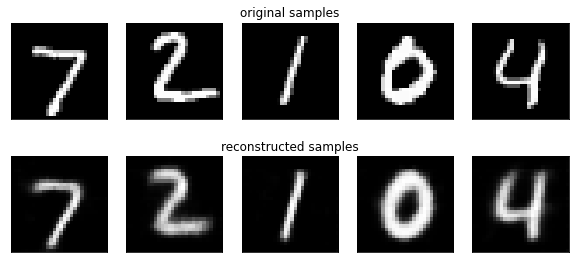

batch loss in training:	  8067.418945
batch loss in training:	  8135.174805
batch loss in training:	  8155.097656
batch loss in training:	  7987.217285
batch loss in training:	  8098.944824
batch loss in training:	  8181.829590
batch loss in training:	  8410.607422
batch loss in training:	  7902.324707
batch loss in training:	  8102.325195
batch loss in training:	  8010.426758
batch loss in training:	  7953.401367
batch loss in training:	  7944.386719
batch loss in training:	  8204.140625
batch loss in training:	  8045.959961
batch loss in training:	  8175.214844
batch loss in training:	  8014.550781
batch loss in training:	  7830.694336
batch loss in training:	  7762.880371
batch loss in training:	  7993.246094
batch loss in training:	  8300.785156
batch loss in training:	  7427.504395
batch loss in training:	  8405.171875
batch loss in training:	  8391.640625
batch loss in training:	  7949.879883
batch loss in training:	  7990.412109
batch loss in training:	  8192.540039
batch loss i

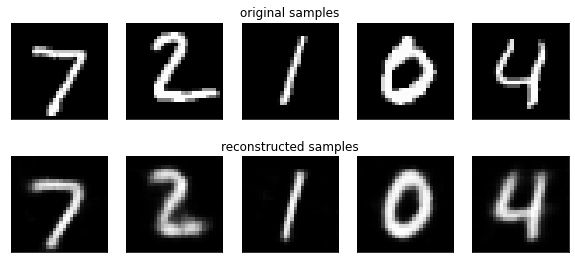

batch loss in training:	  8003.660645
batch loss in training:	  8068.261230
batch loss in training:	  8195.031250
batch loss in training:	  8114.967773
batch loss in training:	  8093.271484
batch loss in training:	  8057.447754
batch loss in training:	  8328.671875
batch loss in training:	  7972.085449
batch loss in training:	  8062.541016
batch loss in training:	  7994.744141
batch loss in training:	  7971.937500
batch loss in training:	  7938.831543
batch loss in training:	  8138.469238
batch loss in training:	  8041.678223
batch loss in training:	  8223.667969
batch loss in training:	  8084.818359
batch loss in training:	  7779.423828
batch loss in training:	  7813.281738
batch loss in training:	  7943.069824
batch loss in training:	  8307.553711
batch loss in training:	  7485.680176
batch loss in training:	  8422.804688
batch loss in training:	  8297.773438
batch loss in training:	  7893.873047
batch loss in training:	  8065.229004
batch loss in training:	  8298.123047
batch loss i

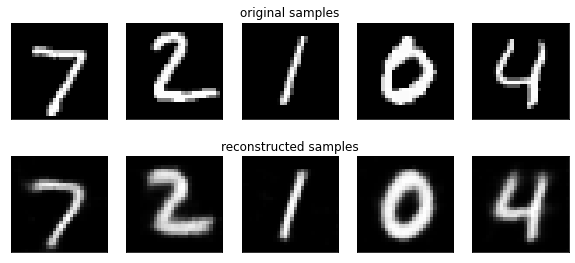

batch loss in training:	  7995.185547
batch loss in training:	  8212.541016
batch loss in training:	  8139.294434
batch loss in training:	  8119.854492
batch loss in training:	  8063.219238
batch loss in training:	  8035.152344
batch loss in training:	  8424.136719
batch loss in training:	  7981.148438
batch loss in training:	  8067.618164
batch loss in training:	  7999.253906
batch loss in training:	  7960.445312
batch loss in training:	  8029.636719
batch loss in training:	  8091.294922
batch loss in training:	  8048.111816
batch loss in training:	  8189.169922
batch loss in training:	  8021.473633
batch loss in training:	  7817.850586
batch loss in training:	  7718.538574
batch loss in training:	  7951.610352
batch loss in training:	  8214.083008
batch loss in training:	  7496.152832
batch loss in training:	  8469.837891
batch loss in training:	  8379.589844
batch loss in training:	  8063.254395
batch loss in training:	  7975.511230
batch loss in training:	  8270.551758
batch loss i

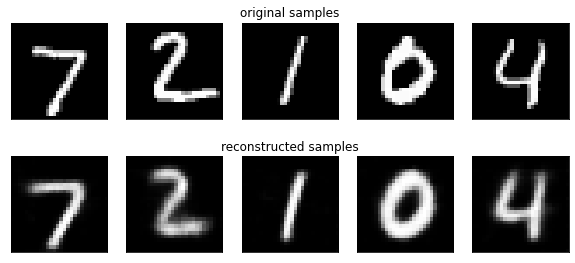

batch loss in training:	  8011.472656
batch loss in training:	  8185.120605
batch loss in training:	  8188.753418
batch loss in training:	  7980.772949
batch loss in training:	  8138.261719
batch loss in training:	  8091.094727
batch loss in training:	  8360.296875
batch loss in training:	  7938.466797
batch loss in training:	  8037.277344
batch loss in training:	  7997.082031
batch loss in training:	  7930.477539
batch loss in training:	  7954.804688
batch loss in training:	  8055.271973
batch loss in training:	  8019.246582
batch loss in training:	  8128.130859
batch loss in training:	  8065.999512
batch loss in training:	  7770.749023
batch loss in training:	  7757.766113
batch loss in training:	  7873.751953
batch loss in training:	  8224.570312
batch loss in training:	  7405.328613
batch loss in training:	  8433.916016
batch loss in training:	  8349.513672
batch loss in training:	  7988.583008
batch loss in training:	  8032.518555
batch loss in training:	  8237.872070
batch loss i

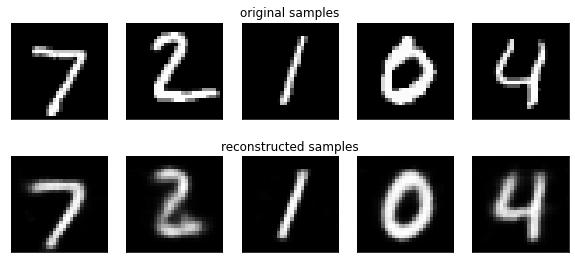

batch loss in training:	  8030.633789
batch loss in training:	  8186.867188
batch loss in training:	  8171.921387
batch loss in training:	  8081.708008
batch loss in training:	  8085.781250
batch loss in training:	  8122.283691
batch loss in training:	  8345.001953
batch loss in training:	  7962.373047
batch loss in training:	  8086.186523
batch loss in training:	  7907.949219
batch loss in training:	  7973.640137
batch loss in training:	  7917.188477
batch loss in training:	  8099.770996
batch loss in training:	  8015.253906
batch loss in training:	  8145.631836
batch loss in training:	  8054.748047
batch loss in training:	  7851.226074
batch loss in training:	  7807.647949
batch loss in training:	  7924.958984
batch loss in training:	  8155.442383
batch loss in training:	  7499.126465
batch loss in training:	  8452.448242
batch loss in training:	  8353.861328
batch loss in training:	  7991.533203
batch loss in training:	  8027.672852
batch loss in training:	  8282.848633
batch loss i

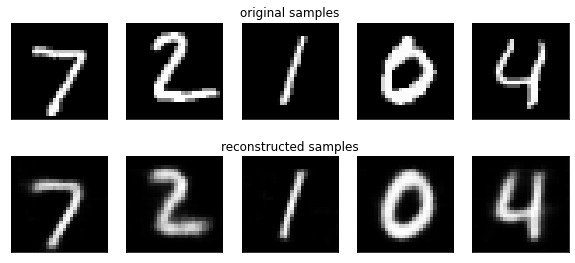

batch loss in training:	  7999.297852
batch loss in training:	  8161.788086
batch loss in training:	  8130.232422
batch loss in training:	  8087.333496
batch loss in training:	  8145.602539
batch loss in training:	  8117.106934
batch loss in training:	  8343.883789
batch loss in training:	  7981.197266
batch loss in training:	  8011.217773
batch loss in training:	  7929.650391
batch loss in training:	  7954.900391
batch loss in training:	  7973.274414
batch loss in training:	  8071.588379
batch loss in training:	  7984.122070
batch loss in training:	  8190.665039
batch loss in training:	  8104.394043
batch loss in training:	  7810.226562
batch loss in training:	  7752.554688
batch loss in training:	  7941.456543
batch loss in training:	  8231.402344
batch loss in training:	  7482.544434
batch loss in training:	  8463.470703
batch loss in training:	  8310.053711
batch loss in training:	  8048.473145
batch loss in training:	  7986.222656
batch loss in training:	  8196.185547
batch loss i

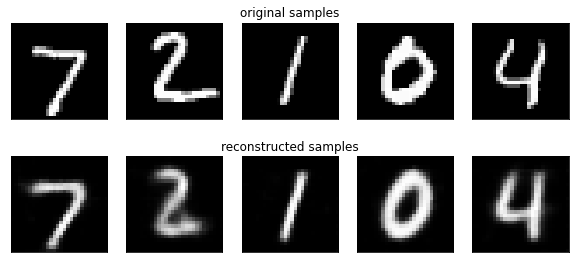

batch loss in training:	  7966.460938
batch loss in training:	  8149.381836
batch loss in training:	  8209.378906
batch loss in training:	  8042.132324
batch loss in training:	  8077.619141
batch loss in training:	  8189.904785
batch loss in training:	  8539.473633
batch loss in training:	  8032.561523
batch loss in training:	  8096.937012
batch loss in training:	  7940.103027
batch loss in training:	  7957.722656
batch loss in training:	  8016.199707
batch loss in training:	  8094.690918
batch loss in training:	  8083.842285
batch loss in training:	  8140.145508
batch loss in training:	  8143.770020
batch loss in training:	  7783.347656
batch loss in training:	  7691.139648
batch loss in training:	  7918.671875
batch loss in training:	  8177.120117
batch loss in training:	  7428.623047
batch loss in training:	  8428.175781
batch loss in training:	  8316.332031
batch loss in training:	  7997.886719
batch loss in training:	  7964.345215
batch loss in training:	  8253.768555
batch loss i

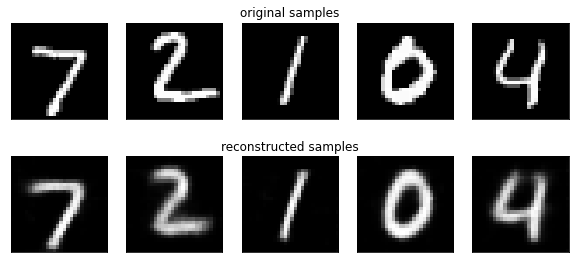

batch loss in training:	  7962.152344
batch loss in training:	  8104.951172
batch loss in training:	  8168.428223
batch loss in training:	  8015.774414
batch loss in training:	  8063.536133
batch loss in training:	  8075.761230
batch loss in training:	  8344.740234
batch loss in training:	  7899.380859
batch loss in training:	  8038.887695
batch loss in training:	  7976.610352
batch loss in training:	  7973.062500
batch loss in training:	  7943.745605
batch loss in training:	  8074.891113
batch loss in training:	  7993.036621
batch loss in training:	  8158.356934
batch loss in training:	  8138.826172
batch loss in training:	  7784.842773
batch loss in training:	  7696.721680
batch loss in training:	  7969.485840
batch loss in training:	  8259.872070
batch loss in training:	  7475.845703
batch loss in training:	  8503.552734
batch loss in training:	  8295.255859
batch loss in training:	  8055.611816
batch loss in training:	  7990.860840
batch loss in training:	  8193.595703
batch loss i

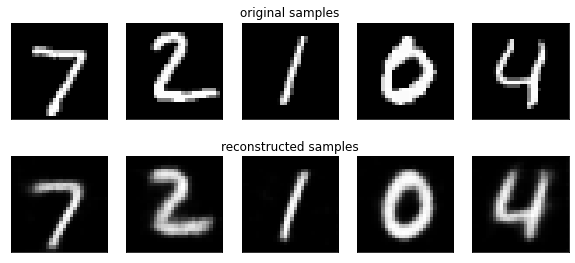

batch loss in training:	  7971.169434
batch loss in training:	  8141.404785
batch loss in training:	  8125.821777
batch loss in training:	  8107.918457
batch loss in training:	  8039.068359
batch loss in training:	  8040.017578
batch loss in training:	  8435.570312
batch loss in training:	  7962.111328
batch loss in training:	  8089.930664
batch loss in training:	  7918.312012
batch loss in training:	  7947.964844
batch loss in training:	  7958.889648
batch loss in training:	  8026.331055
batch loss in training:	  8072.568848
batch loss in training:	  8175.106445
batch loss in training:	  8107.145996
batch loss in training:	  7826.829102
batch loss in training:	  7750.284180
batch loss in training:	  7950.091797
batch loss in training:	  8208.144531
batch loss in training:	  7405.467773
batch loss in training:	  8493.308594
batch loss in training:	  8326.776367
batch loss in training:	  8029.244141
batch loss in training:	  7948.618164
batch loss in training:	  8298.904297
batch loss i

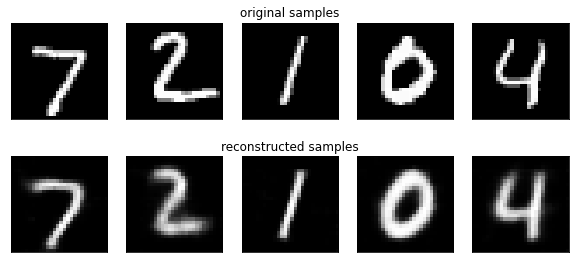

batch loss in training:	  8046.448242
batch loss in training:	  8130.442383
batch loss in training:	  8198.562500
batch loss in training:	  7996.171875
batch loss in training:	  8140.282715
batch loss in training:	  8131.953125
batch loss in training:	  8364.653320
batch loss in training:	  7969.451172
batch loss in training:	  8063.169434
batch loss in training:	  8051.188477
batch loss in training:	  7971.517578
batch loss in training:	  7965.003906
batch loss in training:	  8102.269531
batch loss in training:	  8092.228516
batch loss in training:	  8127.036133
batch loss in training:	  8080.227539
batch loss in training:	  7826.006836
batch loss in training:	  7743.263672
batch loss in training:	  7883.508789
batch loss in training:	  8291.787109
batch loss in training:	  7476.048828
batch loss in training:	  8433.428711
batch loss in training:	  8357.924805
batch loss in training:	  8038.361328
batch loss in training:	  7999.896484
batch loss in training:	  8267.697266
batch loss i

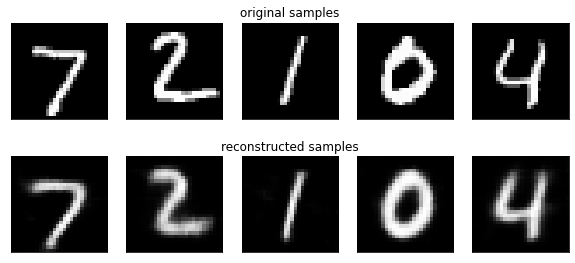

batch loss in training:	  8031.109375
batch loss in training:	  8164.037109
batch loss in training:	  8243.319336
batch loss in training:	  8053.569824
batch loss in training:	  8003.498535
batch loss in training:	  8110.236816
batch loss in training:	  8398.685547
batch loss in training:	  7969.141602
batch loss in training:	  8088.230469
batch loss in training:	  8007.040039
batch loss in training:	  7930.377930
batch loss in training:	  7990.803711
batch loss in training:	  8085.959961
batch loss in training:	  8107.203125
batch loss in training:	  8164.255859
batch loss in training:	  8075.371582
batch loss in training:	  7840.747070
batch loss in training:	  7816.118164
batch loss in training:	  7915.486328
batch loss in training:	  8184.618164
batch loss in training:	  7427.754395
batch loss in training:	  8385.042969
batch loss in training:	  8330.325195
batch loss in training:	  7917.983398
batch loss in training:	  7960.911133
batch loss in training:	  8239.230469
batch loss i

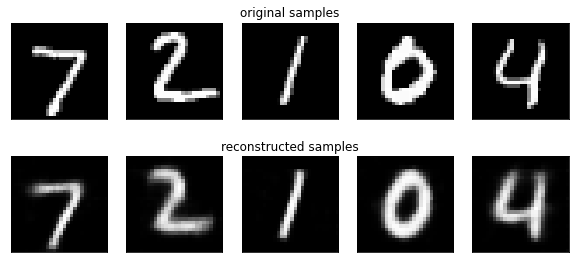

batch loss in training:	  7998.845215
batch loss in training:	  8051.478027
batch loss in training:	  8191.242188
batch loss in training:	  8029.462891
batch loss in training:	  8072.234375
batch loss in training:	  8151.166992
batch loss in training:	  8415.759766
batch loss in training:	  7897.022949
batch loss in training:	  8056.822266
batch loss in training:	  7998.850098
batch loss in training:	  7992.202637
batch loss in training:	  8017.485840
batch loss in training:	  8070.600586
batch loss in training:	  8015.770996
batch loss in training:	  8159.032227
batch loss in training:	  8085.841797
batch loss in training:	  7802.855469
batch loss in training:	  7794.099121
batch loss in training:	  7929.328125
batch loss in training:	  8229.820312
batch loss in training:	  7432.250977
batch loss in training:	  8435.455078
batch loss in training:	  8264.886719
batch loss in training:	  8010.158691
batch loss in training:	  8040.541504
batch loss in training:	  8220.598633
batch loss i

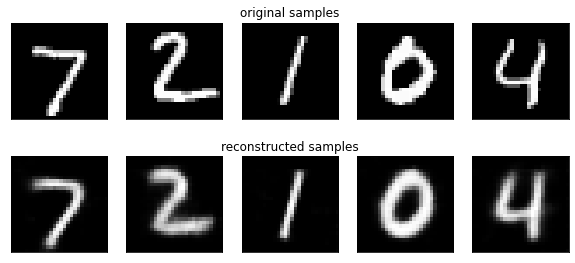

batch loss in training:	  7988.992676
batch loss in training:	  8117.233887
batch loss in training:	  8166.058594
batch loss in training:	  7997.045410
batch loss in training:	  8085.977539
batch loss in training:	  8182.875977
batch loss in training:	  8364.837891
batch loss in training:	  8029.296875
batch loss in training:	  8027.022461
batch loss in training:	  7957.819336
batch loss in training:	  7907.451660
batch loss in training:	  7993.197266
batch loss in training:	  8065.191406
batch loss in training:	  8004.443359
batch loss in training:	  8089.087402
batch loss in training:	  8061.276367
batch loss in training:	  7806.340332
batch loss in training:	  7808.323242
batch loss in training:	  7889.495117
batch loss in training:	  8306.377930
batch loss in training:	  7416.847656
batch loss in training:	  8342.193359
batch loss in training:	  8320.210938
batch loss in training:	  8044.406738
batch loss in training:	  8013.765625
batch loss in training:	  8251.278320
batch loss i

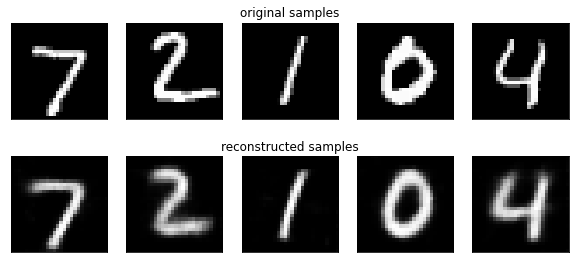

batch loss in training:	  8002.629395
batch loss in training:	  8073.866211
batch loss in training:	  8232.801758
batch loss in training:	  8061.698730
batch loss in training:	  8062.620605
batch loss in training:	  8047.875000
batch loss in training:	  8313.582031
batch loss in training:	  7988.049316
batch loss in training:	  8071.819336
batch loss in training:	  7928.380371
batch loss in training:	  7923.024902
batch loss in training:	  7950.566895
batch loss in training:	  8017.022461
batch loss in training:	  8013.770020
batch loss in training:	  8126.776855
batch loss in training:	  8087.964844
batch loss in training:	  7729.707520
batch loss in training:	  7715.201172
batch loss in training:	  7916.004883
batch loss in training:	  8237.392578
batch loss in training:	  7439.266113
batch loss in training:	  8458.858398
batch loss in training:	  8338.237305
batch loss in training:	  7981.484863
batch loss in training:	  7981.254883
batch loss in training:	  8241.568359
batch loss i

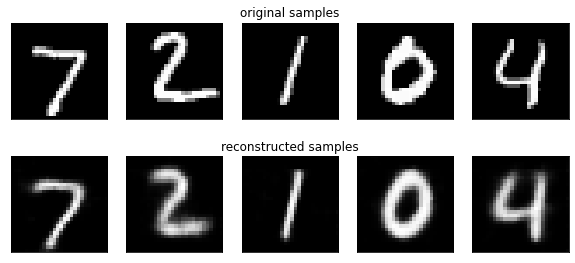

batch loss in training:	  8003.580566
batch loss in training:	  8193.681641
batch loss in training:	  8170.067871
batch loss in training:	  8006.590820
batch loss in training:	  8009.970703
batch loss in training:	  8108.053711
batch loss in training:	  8423.051758
batch loss in training:	  7959.742188
batch loss in training:	  8130.692383
batch loss in training:	  8003.081055
batch loss in training:	  7906.185059
batch loss in training:	  7904.399414
batch loss in training:	  8033.627930
batch loss in training:	  7971.571289
batch loss in training:	  8165.232910
batch loss in training:	  8110.238281
batch loss in training:	  7819.096680
batch loss in training:	  7720.508789
batch loss in training:	  7917.546875
batch loss in training:	  8184.933594
batch loss in training:	  7455.245605
batch loss in training:	  8365.259766
batch loss in training:	  8261.078125
batch loss in training:	  7910.462891
batch loss in training:	  8032.434570
batch loss in training:	  8229.974609
batch loss i

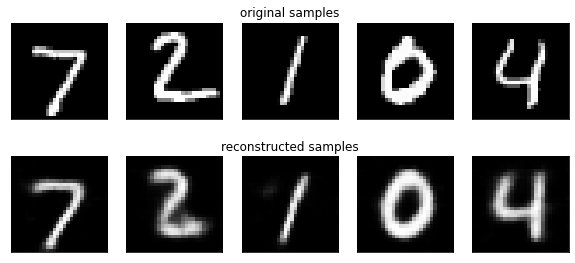

batch loss in training:	  8009.885254
batch loss in training:	  8089.189453
batch loss in training:	  8129.818359
batch loss in training:	  7963.843750
batch loss in training:	  8080.373535
batch loss in training:	  8079.305664
batch loss in training:	  8347.207031
batch loss in training:	  7855.535156
batch loss in training:	  8078.617676
batch loss in training:	  8017.762695
batch loss in training:	  7948.393555
batch loss in training:	  7903.996582
batch loss in training:	  8050.376953
batch loss in training:	  8071.120117
batch loss in training:	  8212.001953
batch loss in training:	  8131.083984
batch loss in training:	  7762.634766
batch loss in training:	  7757.330078
batch loss in training:	  7941.334961
batch loss in training:	  8218.876953
batch loss in training:	  7393.427734
batch loss in training:	  8439.934570
batch loss in training:	  8262.435547
batch loss in training:	  7980.844727
batch loss in training:	  7947.473633
batch loss in training:	  8246.840820
batch loss i

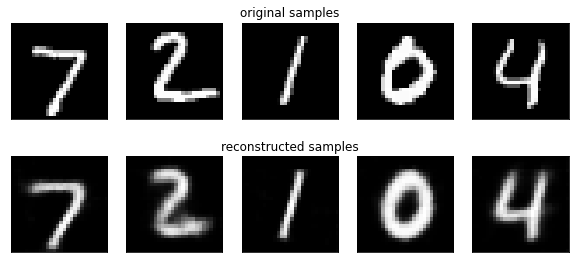

batch loss in training:	  7922.629395
batch loss in training:	  8001.964844
batch loss in training:	  8160.817383
batch loss in training:	  7987.770996
batch loss in training:	  8065.239258
batch loss in training:	  8178.421875
batch loss in training:	  8349.333984
batch loss in training:	  7992.410156
batch loss in training:	  8063.020020
batch loss in training:	  7903.252441
batch loss in training:	  7916.720215
batch loss in training:	  7998.089844
batch loss in training:	  8060.192383
batch loss in training:	  8078.575684
batch loss in training:	  8103.356934
batch loss in training:	  8170.405273
batch loss in training:	  7821.287598
batch loss in training:	  7634.770996
batch loss in training:	  7849.993164
batch loss in training:	  8170.270020
batch loss in training:	  7526.793945
batch loss in training:	  8416.431641
batch loss in training:	  8310.293945
batch loss in training:	  7994.457031
batch loss in training:	  7967.085449
batch loss in training:	  8298.013672
batch loss i

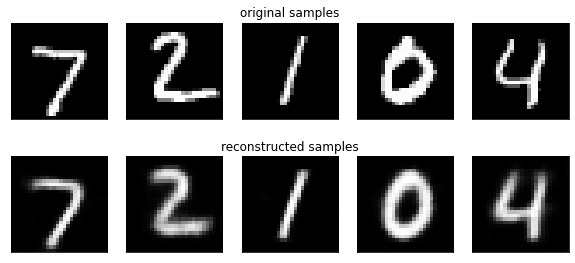

batch loss in training:	  7981.551270
batch loss in training:	  8035.214844
batch loss in training:	  8161.108887
batch loss in training:	  8031.676270
batch loss in training:	  8064.194824
batch loss in training:	  8079.013672
batch loss in training:	  8388.109375
batch loss in training:	  7963.659668
batch loss in training:	  7997.462402
batch loss in training:	  7922.284180
batch loss in training:	  7921.451172
batch loss in training:	  7881.840820
batch loss in training:	  8014.741211
batch loss in training:	  8040.508789
batch loss in training:	  8155.433594
batch loss in training:	  8075.156738
batch loss in training:	  7765.959473
batch loss in training:	  7727.719238
batch loss in training:	  7905.895020
batch loss in training:	  8202.301758
batch loss in training:	  7414.013184
batch loss in training:	  8450.314453
batch loss in training:	  8243.681641
batch loss in training:	  8072.321289
batch loss in training:	  7970.404297
batch loss in training:	  8203.482422
batch loss i

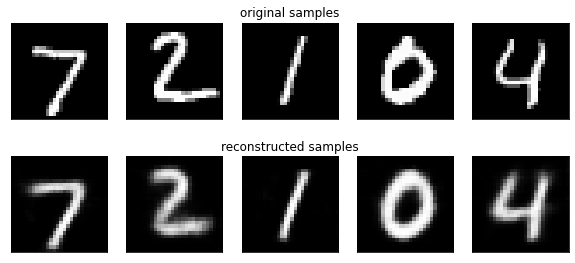

batch loss in training:	  8057.416992
batch loss in training:	  8024.263672
batch loss in training:	  8129.496094
batch loss in training:	  8074.753906
batch loss in training:	  8000.111328
batch loss in training:	  8069.201660
batch loss in training:	  8357.818359
batch loss in training:	  7941.939941
batch loss in training:	  8059.098145
batch loss in training:	  7959.386719
batch loss in training:	  7966.922852
batch loss in training:	  7913.536621
batch loss in training:	  8003.538574
batch loss in training:	  7993.867676
batch loss in training:	  8070.600586
batch loss in training:	  8026.794922
batch loss in training:	  7755.324707
batch loss in training:	  7744.011719
batch loss in training:	  7905.852539
batch loss in training:	  8203.328125
batch loss in training:	  7362.785156
batch loss in training:	  8432.530273
batch loss in training:	  8307.666992
batch loss in training:	  7964.792969
batch loss in training:	  7955.228516
batch loss in training:	  8169.884277
batch loss i

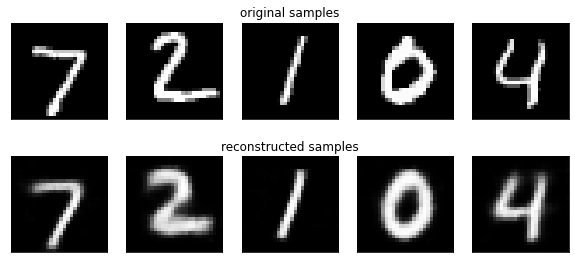

batch loss in training:	  8007.991211
batch loss in training:	  8088.686523
batch loss in training:	  8245.257812
batch loss in training:	  7979.190918
batch loss in training:	  8051.373047
batch loss in training:	  8047.165527
batch loss in training:	  8380.470703
batch loss in training:	  7919.179688
batch loss in training:	  8059.297852
batch loss in training:	  7854.134277
batch loss in training:	  7904.746094
batch loss in training:	  7894.024902
batch loss in training:	  8040.739258
batch loss in training:	  7991.216797
batch loss in training:	  8108.014648
batch loss in training:	  8071.112793
batch loss in training:	  7822.108398
batch loss in training:	  7749.265625
batch loss in training:	  7917.923340
batch loss in training:	  8171.897461
batch loss in training:	  7424.645020
batch loss in training:	  8389.119141
batch loss in training:	  8338.166992
batch loss in training:	  8008.417969
batch loss in training:	  7992.195312
batch loss in training:	  8217.798828
batch loss i

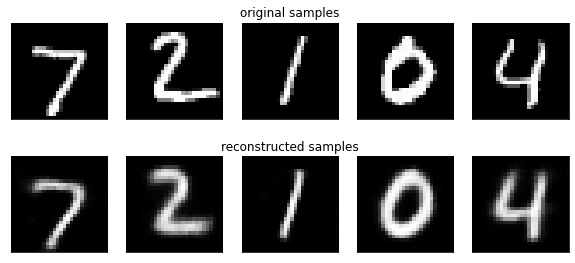

batch loss in training:	  7965.885742
batch loss in training:	  8023.825195
batch loss in training:	  8181.561523
batch loss in training:	  7992.604004
batch loss in training:	  8060.875977
batch loss in training:	  8057.720703
batch loss in training:	  8293.912109
batch loss in training:	  7919.874023
batch loss in training:	  8055.446289
batch loss in training:	  7919.880859
batch loss in training:	  7928.172363
batch loss in training:	  7955.930176
batch loss in training:	  8048.274902
batch loss in training:	  7920.783691
batch loss in training:	  8177.227051
batch loss in training:	  8072.637695
batch loss in training:	  7779.003906
batch loss in training:	  7691.797363
batch loss in training:	  7855.973633
batch loss in training:	  8250.982422
batch loss in training:	  7482.262207
batch loss in training:	  8324.230469
batch loss in training:	  8228.674805
batch loss in training:	  7919.392578
batch loss in training:	  7907.141113
batch loss in training:	  8127.806641
batch loss i

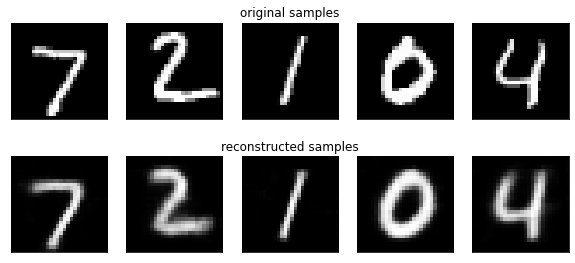

batch loss in training:	  7960.452637
batch loss in training:	  8043.422852
batch loss in training:	  8128.820801
batch loss in training:	  8060.709473
batch loss in training:	  8025.278809
batch loss in training:	  7980.518066
batch loss in training:	  8347.993164
batch loss in training:	  8021.248047
batch loss in training:	  8046.670898
batch loss in training:	  7973.564453
batch loss in training:	  7939.164551
batch loss in training:	  7906.955078
batch loss in training:	  7983.503906
batch loss in training:	  7963.188965
batch loss in training:	  8156.239746
batch loss in training:	  8103.273438
batch loss in training:	  7835.433105
batch loss in training:	  7730.326172
batch loss in training:	  7888.048828
batch loss in training:	  8236.279297
batch loss in training:	  7407.587402
batch loss in training:	  8407.949219
batch loss in training:	  8317.979492
batch loss in training:	  7959.791992
batch loss in training:	  7921.932129
batch loss in training:	  8226.712891
batch loss i

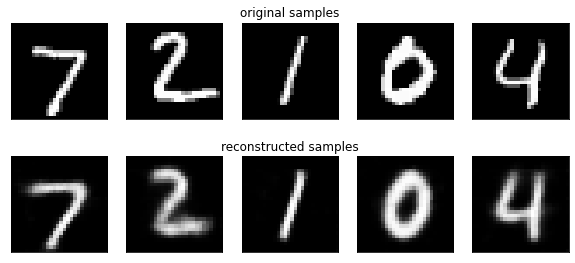

In [17]:
num_epochs = 100
for epoch in range(num_epochs):
   train_loss = train_epoch(VAE,device,train_loader,optim)
   val_loss = test_epoch(VAE,device,valid_loader)
   print('\n epoch {}/{} \t training loss {:.3f} \t validation loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   show_MNIST_outputs(VAE.encoder,VAE.decoder,n=5)